# Autodecoder Latent Space 3D Diffusion

ShapeNetCoreMini Dataset Link: https://drive.google.com/drive/folders/1UZ5N7A2w9vbzYJMLmKwsrW6g9DCvI0b8?usp=drive_link

# Imports

In [ ]:
!pip install torch torchvision datasets
!pip install einops
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 658.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 745.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=76cea8d47f94ca2639172e3ada685a6e84434e651348ebe8a60b28d56113435e
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=81df34a013ceb3b276234bab052335cfedb645fcab865004226d92d42f66d726
  Store

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.stateless import functional_call
from torch.utils.data import DataLoader, Dataset, IterableDataset
from datasets import load_dataset
import einops
import matplotlib.pyplot as plt
import numpy as np
import skimage
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype, resize
from einops import rearrange
import h5py

from pytorch3d.utils import opencv_from_cameras_projection
from pytorch3d.renderer.mesh import TexturesAtlas
from pytorch3d.renderer.cameras import look_at_view_transform
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.common.datatypes import Device
from pytorch3d.io import load_obj
from pytorch3d.renderer import (
    PerspectiveCameras,
    HardPhongShader,
    MeshRasterizer,
    MeshRenderer,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
)

import random
import sys
import collections
import json
import warnings
import os
from os import path
from pathlib import Path
from typing import Dict, List, Optional, Tuple

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# ShapeNET Dataset Rendering and Management

In [ ]:
def collate_batched_meshes(batch: List[Dict]):
    if batch is None or len(batch) == 0:
        return None
    collated_dict = {}
    for k in batch[0].keys():
        collated_dict[k] = [d[k] for d in batch]

    collated_dict["mesh"] = None
    if {"verts", "faces"}.issubset(collated_dict.keys()):
        textures = None
        if "textures" in collated_dict:
            textures = TexturesAtlas(atlas=collated_dict["textures"])
        collated_dict["mesh"] = Meshes(
            verts=collated_dict["verts"],
            faces=collated_dict["faces"],
            textures=textures,
        )
    return collated_dict

In [ ]:
class ShapeNetDataset(Dataset):

    def __init__(self) -> None:

        self.synset_ids = []
        self.model_ids = []
        self.synset_inv = {}
        self.synset_start_idxs = {}
        self.synset_num_models = {}
        self.shapenet_dir = ""
        self.model_dir = "models/model_normalized.obj"
        self.load_textures = True
        self.texture_resolution = 4

    def __len__(self) -> int:

        return len(self.model_ids)

    def __getitem__(self, idx) -> Dict:

        raise NotImplementedError()

    def mesh_dict(self, idx) -> Dict:

        raise NotImplementedError()

    def _get_item_ids(self, idx) -> Dict:

        model = {}
        model["synset_id"] = self.synset_ids[idx]
        model["model_id"] = self.model_ids[idx]
        return model

    def _load_mesh(self, model_path) -> Tuple:
        verts, faces, aux = load_obj(
            model_path,
            create_texture_atlas=self.load_textures,
            load_textures=self.load_textures,
            texture_atlas_size=self.texture_resolution,
        )
        if self.load_textures:
            textures = aux.texture_atlas
            if textures is None:
                textures = verts.new_ones(
                    faces.verts_idx.shape[0],
                    self.texture_resolution,
                    self.texture_resolution,
                    3,
                )
        else:
            textures = None

        return verts, faces.verts_idx, textures

    def convert_camera(self, cameras, image_size):
        R = cameras.R.clone()
        T = cameras.T.clone()
        T[:, :2] *= -1
        R[:, :, :2] *= -1
        R = R.permute(0, 2, 1)

        E = torch.eye(4)
        E[:3, :3] = R.squeeze()
        E[:3, 3] = T.squeeze()

        image_dim = torch.tensor([[image_size, image_size]]).to(R).flip(dims=(1,))
        scale = image_dim.to(R).min(dim=1, keepdim=True)[0] / 2.0
        scale = scale.expand(-1, 2)
        c0 = image_dim / 2.0

        principal_point = -cameras.principal_point * scale + c0
        focal_length = cameras.focal_length * scale
        K = torch.zeros_like(R)
        K[:, :2, 2] = principal_point
        K[:, 2, 2] = 1.0
        K[:, 0, 0] = focal_length[:, 0]
        K[:, 1, 1] = focal_length[:, 1]
        K = K.squeeze()

        return E, K

    def render(
        self,
        model_ids: Optional[List[str]] = None,
        categories: Optional[List[str]] = None,
        sample_nums: Optional[List[int]] = None,
        idxs: Optional[List[int]] = None,
        shader_type=HardPhongShader,
        device: Device = "cpu",
        **kwargs,
    ) -> torch.Tensor:

        idxs = self._handle_render_inputs(model_ids, categories, sample_nums, idxs)
        models = [self.mesh_dict(idx) for idx in idxs]
        meshes = collate_batched_meshes(models)["mesh"]
        if meshes.textures is None:
            meshes.textures = TexturesVertex(
                verts_features=torch.ones_like(meshes.verts_padded(), device=device)
            )
        labels = [model['label'] for model in models]
        meshes = meshes.to(device)

        cameras = kwargs.get("cameras", PerspectiveCameras()).to(device)
        if len(cameras) != 1 and len(cameras) % len(meshes) != 0:
            raise ValueError("Mismatch between batch dims of cameras and meshes.")
        if len(cameras) > 1:
            meshes = meshes.extend(len(cameras) // len(meshes))
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=kwargs.get("raster_settings", RasterizationSettings()),
            ),
            shader=shader_type(
                device=device,
                cameras=cameras,
                lights=kwargs.get("lights", PointLights()).to(device),
            ),
        )

        image_size = kwargs.get("raster_settings", RasterizationSettings()).image_size
        E, K = self.convert_camera(cameras, image_size)

        return {
            "image": renderer(meshes).squeeze()[:, :, :3],
            "intrinsics": K,
            "extrinsics": torch.inverse(E),
            "label": labels[0]
        }


    def _handle_render_inputs(
        self,
        model_ids: Optional[List[str]] = None,
        categories: Optional[List[str]] = None,
        sample_nums: Optional[List[int]] = None,
        idxs: Optional[List[int]] = None,
    ) -> List[int]:

        if model_ids is not None and len(model_ids) > 0:
            idxs = []
            for model_id in model_ids:
                if model_id not in self.model_ids:
                    raise ValueError(
                        "model_id %s not found in the loaded dataset." % model_id
                    )
                idxs.append(self.model_ids.index(model_id))

        elif categories is not None and len(categories) > 0:
            sample_nums = [1] if sample_nums is None else sample_nums
            if len(categories) != len(sample_nums) and len(sample_nums) != 1:
                raise ValueError(
                    "categories and sample_nums needs to be of the same length or "
                    "sample_nums needs to be of length 1."
                )

            idxs_tensor = torch.empty(0, dtype=torch.int32)
            for i in range(len(categories)):
                category = self.synset_inv.get(categories[i], categories[i])
                if category not in self.synset_inv.values():
                    raise ValueError(
                        "Category %s is not in the loaded dataset." % category
                    )
                sample_num = sample_nums[i] if len(sample_nums) > 1 else sample_nums[0]
                sampled_idxs = self._sample_idxs_from_category(
                    sample_num=sample_num, category=category
                )
                idxs_tensor = torch.cat((idxs_tensor, sampled_idxs))
            idxs = idxs_tensor.tolist()
        elif idxs is not None and len(idxs) > 0:
            if any(idx < 0 or idx >= len(self.model_ids) for idx in idxs):
                raise IndexError(
                    "One or more idx values are out of bounds. Indices need to be"
                    "between 0 and %s." % (len(self.model_ids) - 1)
                )
        else:
            sample_nums = [1] if sample_nums is None else sample_nums
            if len(sample_nums) > 1:
                msg = (
                    "More than one sample sizes specified, now sampling "
                    "%d models from the dataset." % sample_nums[0]
                )
                warnings.warn(msg)
            idxs = self._sample_idxs_from_category(sample_nums[0])
        return idxs

    def _sample_idxs_from_category(
        self, sample_num: int = 1, category: Optional[str] = None
    ) -> List[int]:

        start = self.synset_start_idxs[category] if category is not None else 0
        range_len = (
            self.synset_num_models[category] if category is not None else self.__len__()
        )
        replacement = sample_num > range_len
        sampled_idxs = (
            torch.multinomial(
                torch.ones((range_len), dtype=torch.float32),
                sample_num,
                replacement=replacement,
            )
            + start
        )
        if replacement:
            msg = (
                "Sample size %d is larger than the number of objects in %s, "
                "values sampled with replacement."
            ) % (
                sample_num,
                "category " + category if category is not None else "all categories",
            )
            warnings.warn(msg)
        return sampled_idxs

class ShapeNetCoreDataset(ShapeNetDataset):
    def __init__(
        self,
        data_dir,
        num_images=30,
        image_size=128,
        synsets=None,
        load_textures: bool = True,
        texture_resolution: int = 4,
    ) -> None:

        super().__init__()
        self.shapenet_dir = data_dir
        self.num_images = num_images
        self.image_size = image_size
        self.load_textures = load_textures
        self.texture_resolution = texture_resolution
        self.model_dir = "models/model_normalized.obj"
        dict_file = "shapenet_synset_dict_v2.json"

        with open(path.join(data_dir, dict_file), "r") as read_dict:
            self.synset_dict = json.load(read_dict)
        self.synset_inv = {label: offset for offset, label in self.synset_dict.items()}

        if synsets is not None:
            synset_set = set()
            for synset in synsets:
                if (synset in self.synset_dict.keys()) and (
                    path.isdir(path.join(data_dir, synset))
                ):
                    synset_set.add(synset)
                elif (synset in self.synset_inv.keys()) and (
                    (path.isdir(path.join(data_dir, self.synset_inv[synset])))
                ):
                    synset_set.add(self.synset_inv[synset])
                else:
                    msg = (
                        "Synset category %s either not part of ShapeNetCore dataset "
                        "or cannot be found in %s."
                    ) % (synset, data_dir)
                    warnings.warn(msg)
        else:
            synset_set = {
                synset
                for synset in os.listdir(data_dir)
                if path.isdir(path.join(data_dir, synset))
                and synset in self.synset_dict
            }

        synset_not_present = set(self.synset_dict.keys()).difference(synset_set)
        [self.synset_inv.pop(self.synset_dict[synset]) for synset in synset_not_present]

        if len(synset_not_present) > 0:
            msg = (
                "The following categories are included in ShapeNetCore ver.%d's "
                "official mapping but not found in the dataset location %s: %s"
                ""
            ) % (2, data_dir, ", ".join(synset_not_present))
            warnings.warn(msg)

        for synset in synset_set:
            self.synset_start_idxs[synset] = len(self.synset_ids)
            for model in os.listdir(path.join(data_dir, synset)):
                if not path.exists(path.join(data_dir, synset, model, self.model_dir)):
                    msg = (
                        "Object file not found in the model directory %s "
                        "under synset directory %s."
                    ) % (model, synset)
                    warnings.warn(msg)
                    continue
                self.synset_ids.append(synset)
                self.model_ids.append(model)
            model_count = len(self.synset_ids) - self.synset_start_idxs[synset]
            self.synset_num_models[synset] = model_count

    def mesh_dict(self, idx: int) -> Dict:

        model = self._get_item_ids(idx)
        model_path = path.join(self.shapenet_dir, model["synset_id"], model["model_id"], self.model_dir)
        verts, faces, textures = self._load_mesh(model_path)
        return {**model, "verts": verts, "faces": faces, "textures": textures, "label": self.synset_dict[model["synset_id"]]}

    def save_renders(self):

        rendered_dir = os.path.join(self.shapenet_dir, "Rendered")
        hdf5_filename = os.path.join(rendered_dir, "renders.hdf5")
        os.makedirs(rendered_dir, exist_ok=True)

        with h5py.File(hdf5_filename, "w") as hdf5_file:
            for idx in range(len(self)):
                model_data = self._get_item_ids(idx)
                synset_id, model_id = model_data["synset_id"], model_data["model_id"]
                group_id = f"{synset_id}/{model_id}"
                model_group = hdf5_file.create_group(group_id)

                image_group = model_group.create_group("image")
                extrinsics_group = model_group.create_group("extrinsics")

                rendered_data = self.render_object(idx)
                for i, data in enumerate(rendered_data):
                    img_data = data["image"].numpy()
                    image_group.create_dataset(f"image_{i}", data=img_data)

                    extrinsics_data = data["extrinsics"].numpy()
                    extrinsics_group.create_dataset(f"extrinsics_{i}", data=extrinsics_data)

                intrinsics_data = data["intrinsics"].numpy()
                model_group.create_dataset("intrinsics.txt", data=intrinsics_data)

                print(f"Saved rendered data for model {model_id} in synset {synset_id}")


    def render_object(self, idx: int):

        elevations = torch.linspace(0, 360, self.num_images)
        azimuths = torch.linspace(-180, 180, self.num_images)
        renders = []

        for elev, azim in zip(elevations, azimuths):
            R, T = look_at_view_transform(dist=1, elev=elev, azim=azim)
            cameras = PerspectiveCameras(R=R, T=T)
            lights = PointLights(location=[[0.0, 0.0, -3.0]])
            raster_settings = RasterizationSettings(image_size=self.image_size)

            render = self.render(
                idxs=[idx],
                shader_type=HardPhongShader,
                cameras=cameras,
                raster_settings=raster_settings,
                lights=lights
            )

            renders.append(render)

        return renders

In [ ]:
def get_opencv_pixel_coordinates(y_resolution, x_resolution):

    i, j = torch.meshgrid(torch.linspace(0, 1, steps=x_resolution),
                          torch.linspace(0, 1, steps=y_resolution))

    xy_pix = torch.stack([i.float(), j.float()], dim=-1).permute(1, 0, 2)
    return xy_pix

In [ ]:
import h5py
import torch
import numpy as np
import random
from skimage.transform import resize
from torch.utils.data import IterableDataset
from einops import rearrange
import io
import imageio
import skimage

def parse_image(hdf5_dataset):
    img = hdf5_dataset[...]
    img = skimage.img_as_float32(img)
    return img

def parse_intrinsics(hdf5_dataset):
    intrinsics = hdf5_dataset[...]
    return torch.from_numpy(intrinsics)

def parse_extrinsics(hdf5_dataset):
    pose = hdf5_dataset[...]
    return torch.from_numpy(pose)

class ShapeNetIterableDataset(IterableDataset):
    def __init__(self, hdf5_file_path, synset_id='03261776', model_id=None, max_num_instances=None, img_sidelength=None):
        self.f = h5py.File(hdf5_file_path, 'r')[synset_id]
        self.instances = sorted(list(self.f.keys()))
        self.img_sidelength = img_sidelength

        if model_id:
            self.instances = [model_id]
        elif max_num_instances:
            self.instances = self.instances[:max_num_instances]

    def view(self, model_id='937cdf200b33bdfd1aec2282dd8bc87a'):

        instance = self.f[model_id]
        images = instance['image']
        cols = 5
        rows = (len(images) + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))
        for i, image in enumerate(images.values()):
            image = parse_image(image).reshape(128, 128, 3)
            image = image[32:-32, 32:-32]
            if self.img_sidelength is not None and image.shape[0] != self.img_sidelength:
                image = resize(image, (self.img_sidelength, self.img_sidelength), anti_aliasing=False, order=0)
            ax = axs[i // cols, i % cols]
            ax.imshow(image)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self.instances)

    def __iter__(self, override_idx=None):
        while True:
            if override_idx is not None:
                idx = override_idx
            else:
                idx = random.randint(0, len(self.instances) - 1)

            key = self.instances[idx]
            instance = self.f[key]
            images = instance['image']
            extrinsics = instance['extrinsics']
            image_keys = list(images.keys())
            extrinsic_keys = list(extrinsics.keys())

            observation_idx = np.random.randint(0, len(image_keys))
            image = parse_image(images[image_keys[observation_idx]])

            xy_pixels = get_opencv_pixel_coordinates(*image.shape[:2])
            image = image[32:-32, 32:-32]
            xy_pixels = xy_pixels[32:-32, 32:-32]

            if self.img_sidelength is not None and image.shape[0] != self.img_sidelength:
                image = resize(image, (self.img_sidelength, self.img_sidelength), anti_aliasing=False, order=0)
                xy_pixels = resize(xy_pixels, (self.img_sidelength, self.img_sidelength), anti_aliasing=False, order=0)

            xy_pixels = rearrange(xy_pixels, 'i j c -> (i j) c')
            extrinsics = parse_extrinsics(extrinsics[extrinsic_keys[observation_idx]])
            image = rearrange(image, 'i j c -> (i j) c')
            intrinsics = parse_intrinsics(instance['intrinsics.txt'])
            intrinsics[:2, :3] /= 128.

            model_input = {
                'extrinsics': extrinsics,
                'intrinsics': intrinsics,
                'xy_pixels': xy_pixels,
                'idx': torch.tensor([idx])
            }

            yield model_input, image


In [ ]:
data_dir = "/content/drive/My Drive/Colab Notebooks/6.S980/Project/ShapeNetCoreMini/"
shapenet = ShapeNetCoreDataset(data_dir=data_dir, num_images=30, image_size=128)

<ipython-input-5-5d98f8d3da1b>:272: UserWarning: The following categories are included in ShapeNetCore ver.2's official mapping but not found in the dataset location /content/drive/My Drive/Colab Notebooks/6.S980/Project/ShapeNetCoreMini/: 02843684, 03991062, 02747177, 04460130, 04330267, 04074963, 03325088, 03001627, 03085013, 04256520, 02880940, 02992529, 02946921, 04099429, 04468005, 03759954, 04225987, 02828884, 03636649, 02924116, 02876657, 03046257, 03790512, 04554684, 04379243, 03761084, 03624134, 03938244, 02818832, 03710193, 03928116, 02942699, 03513137, 02801938, 02773838, 02871439, 02691156, 03337140, 03207941, 03593526, 02808440, 03642806, 03691459, 04004475, 04401088, 04090263, 03211117, 03467517, 03948459, 04530566, 03797390, 02954340, 02933112, 02958343
  warnings.warn(msg)


In [ ]:
shapenet.save_renders()

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/mtl_io.py:102: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


Saved rendered data for model 937cdf200b33bdfd1aec2282dd8bc87a in synset 03261776
Saved rendered data for model 26e186ab10abad8ee6873d49607c1f87 in synset 03261776
Saved rendered data for model c6d19db35f69bae7b6d9c2cee7f2f72b in synset 03261776
Saved rendered data for model 5b2847f952068fd8992fd3dac901d508 in synset 03261776
Saved rendered data for model 2b28e2a5080101d245af43a64155c221 in synset 03261776
Saved rendered data for model 49b17a26edadad7f46619c79b20f2c6e in synset 03261776
Saved rendered data for model f5d210ff14ca9d29b6d9c2cee7f2f72b in synset 03261776
Saved rendered data for model ea885955cb82b3cee074faa875b76f82 in synset 03261776
Saved rendered data for model a959980585058ee42764cfba57a5de73 in synset 03261776
Saved rendered data for model 4f9e3eac5026bdfc50b69fcb22e78050 in synset 03261776
Saved rendered data for model 1d4f9c324d6388a9b904f4192b538029 in synset 03261776
Saved rendered data for model 719b4249339e7eb4c030d1f2c16e4c51 in synset 03261776
Saved rendered d

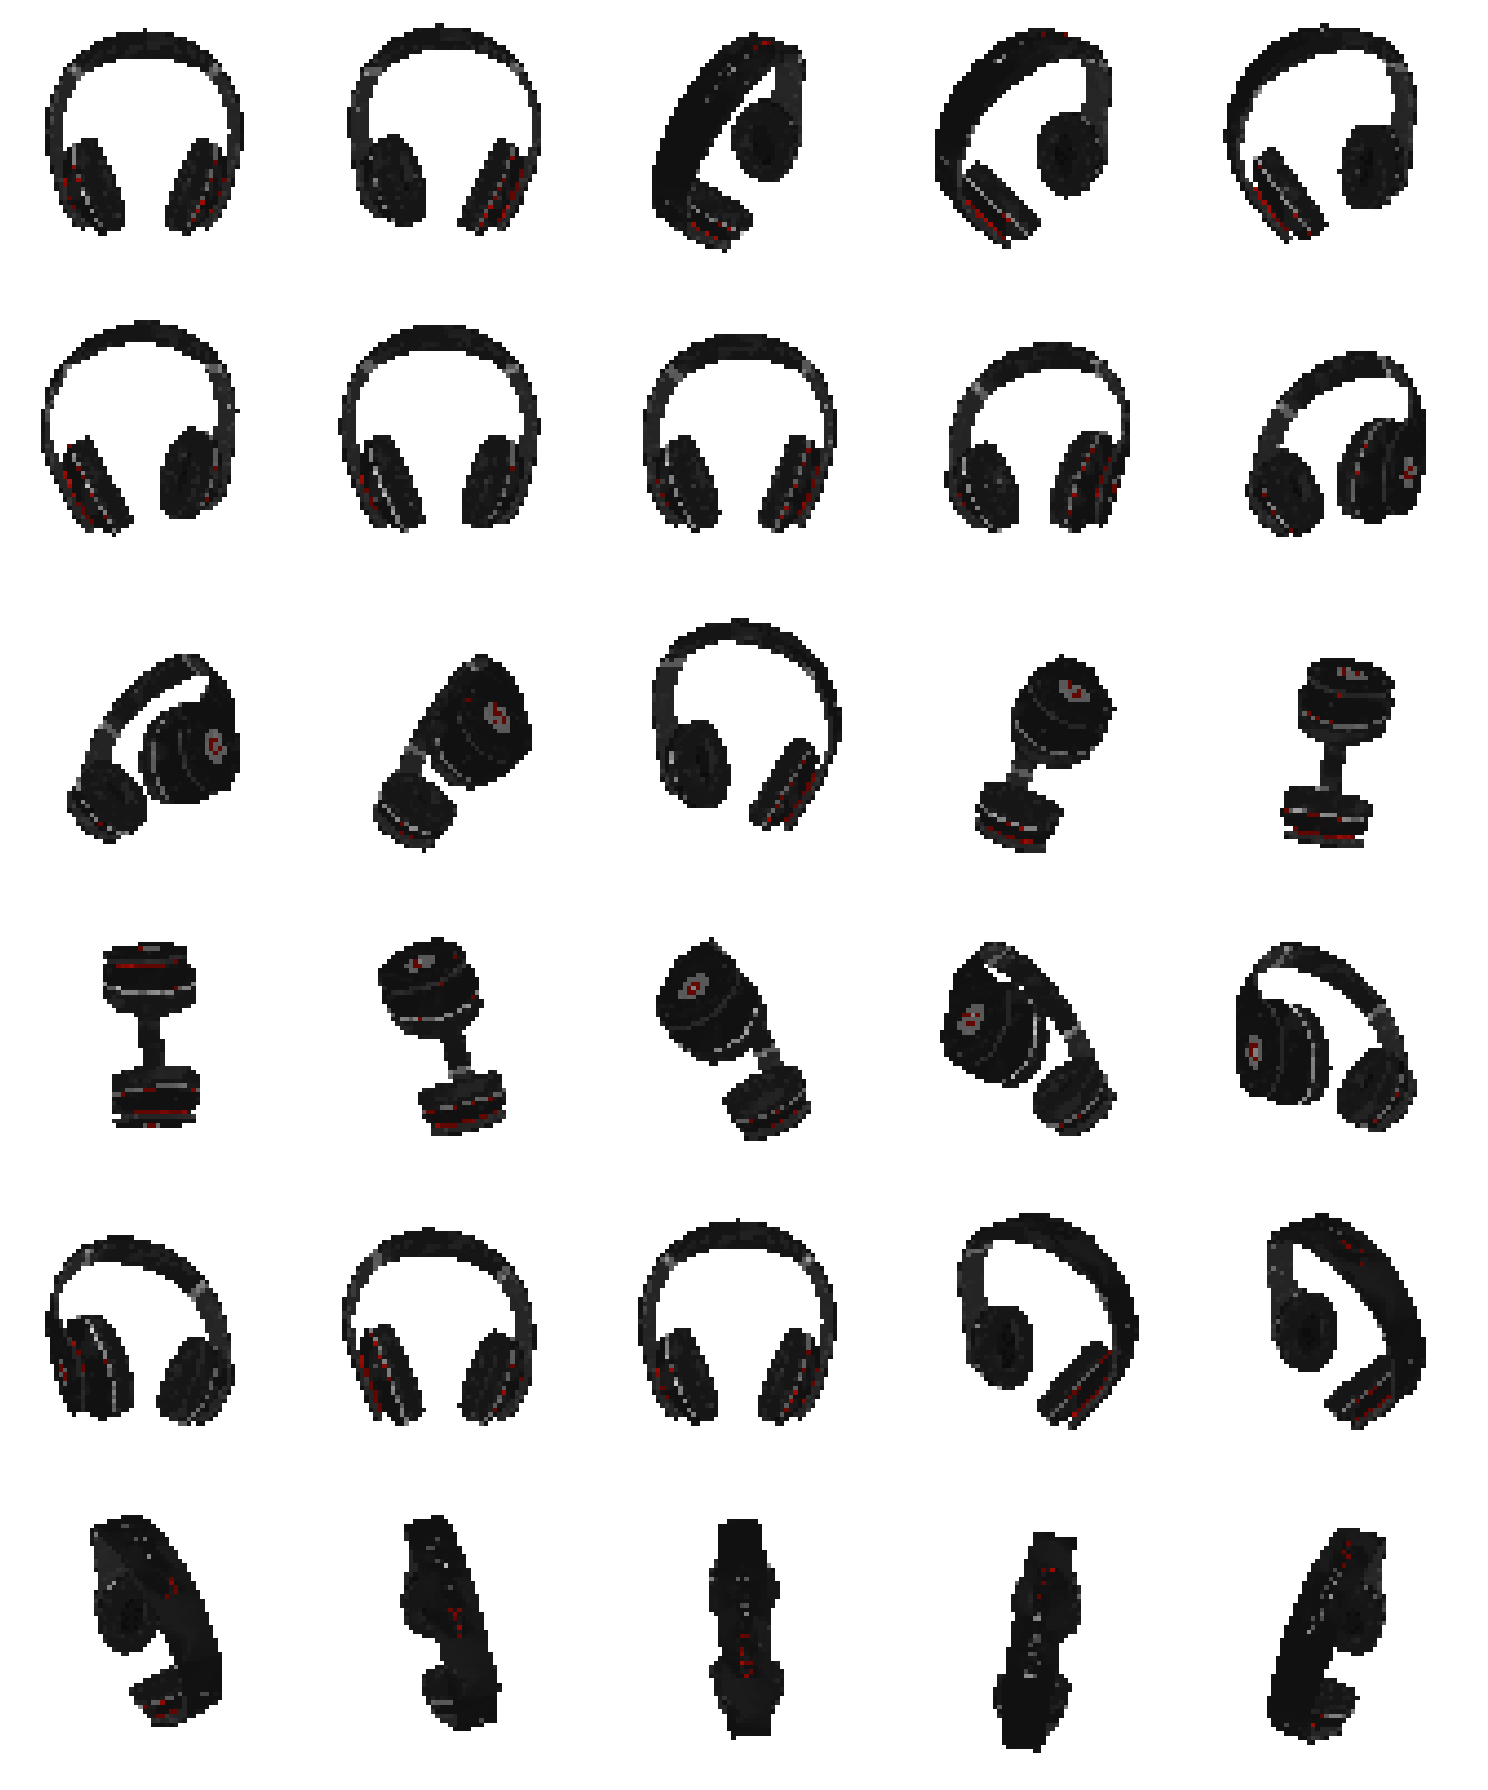

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/6.S980/Project/ShapeNetCoreMini/Rendered/renders.hdf5"
dataset = ShapeNetIterableDataset(path, synset_id='03261776', model_id='937cdf200b33bdfd1aec2282dd8bc87a', img_sidelength=64)
dataset.view()

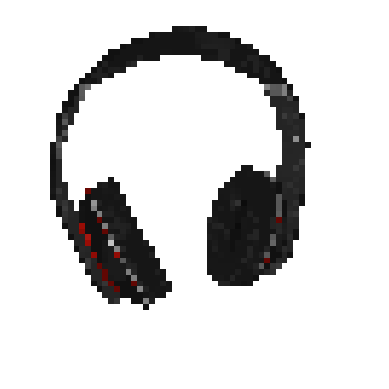



Intrinsics:
[[0.5 0.  0.5]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


Extrinsics:
[[-0.948  0.102 -0.303  0.303]
 [ 0.    -0.948 -0.319  0.319]
 [-0.319 -0.303  0.898 -0.898]
 [ 0.     0.     0.     1.   ]]


Pixel Coordinates Shape: torch.Size([4096, 2])


In [ ]:
mi, img = next(iter(dataset))
img = img.reshape(64, 64, 3)
intrinsics, extrinsics, xy_pixels = mi['intrinsics'], mi['extrinsics'], mi['xy_pixels']

plt.imshow(img)
plt.axis('off')
plt.show()

print('\n')
np.set_printoptions(precision=3, suppress=True)
print(f'Intrinsics:\n{intrinsics.cpu().numpy()}')
print('\n')
print(f'Extrinsics:\n{extrinsics.cpu().numpy()}')
print('\n')
print(f'Pixel Coordinates Shape: {xy_pixels.shape}')

# Convolutional Decoder and NeRF Framework

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv2d):
        # torch.nn.init.xavier_normal_(m.weight)
        # torch.nn.init.uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight)

def to_gpu(ob):
    if isinstance(ob, collections.abc.Mapping):
        return {k: to_gpu(v) for k, v in ob.items()}
    elif isinstance(ob, tuple):
        return tuple(to_gpu(k) for k in ob)
    elif isinstance(ob, list):
        return [to_gpu(k) for k in ob]
    else:
        try:
            return ob.cuda()
        except:
            return ob

def fit(
    model: nn.Module,
    data_iterator,
    loss_fn,
    resolution: Tuple,
    optimizer,
    plotting_function = None,
    steps_til_summary = 500,
    total_steps=2001
   ):

    losses = []
    for step in range(total_steps):
        model_input, ground_truth = next(data_iterator)
        model_input, ground_truth = to_gpu(model_input), to_gpu(ground_truth)
        model_output = model(model_input)
        loss = loss_fn(model_output, ground_truth, model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not step % steps_til_summary:
            print(f"Step {step}: loss = {float(loss.detach().cpu()):.5f}")

            if plotting_function is not None:
                plotting_function(model_output, ground_truth, resolution)

    return model_output

def plot_output_ground_truth(model_output, ground_truth, resolution):
    img, depth = model_output

    img = img[0]
    depth = depth[0]
    gt = ground_truth[0]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), squeeze=False)
    axes[0, 0].imshow(img.cpu().view(*resolution).detach().numpy())
    axes[0, 0].set_title("Trained MLP")
    axes[0, 1].imshow(gt.cpu().view(*resolution).detach().numpy())
    axes[0, 1].set_title("Ground Truth")

    depth = depth.cpu().view(*resolution[:2]).detach().numpy()
    axes[0, 2].imshow(depth, cmap='Greys')
    axes[0, 2].set_title("Depth")

    for i in range(3):
        axes[0, i].set_axis_off()

    plt.show()

def mse_loss(mlp_out, gt, model):
    img, depth = mlp_out
    return ((img - gt)**2).mean()

def homogenize_points(points: torch.Tensor):

    ones = torch.ones_like(points[..., :1], device=points.device)
    return torch.cat((points, ones), dim=-1)


def homogenize_vecs(vectors: torch.Tensor):

    zeros = torch.zeros_like(vectors[..., :1], device=vectors.device)
    return torch.cat((vectors, zeros), dim=-1)


def unproject(
    xy_pix: torch.Tensor,
    z: torch.Tensor,
    intrinsics: torch.Tensor
    ) -> torch.Tensor:

    xy_pix_hom = homogenize_points(xy_pix)
    xyz_cam = torch.einsum('...ij,...kj->...ki', intrinsics.inverse(), xy_pix_hom)
    xyz_cam *= z
    return xyz_cam


def transform_world2cam(xyz_world_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:

    world2cam = torch.inverse(cam2world)
    return transform_rigid(xyz_world_hom, world2cam)


def transform_cam2world(xyz_cam_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:

    return transform_rigid(xyz_cam_hom, cam2world)


def transform_rigid(xyz_hom: torch.Tensor, T: torch.Tensor) -> torch.Tensor:

    return torch.einsum('...ij,...kj->...ki', T, xyz_hom)


def get_unnormalized_cam_ray_directions(xy_pix:torch.Tensor,
                                        intrinsics:torch.Tensor) -> torch.Tensor:

    return unproject(xy_pix, torch.ones_like(xy_pix[..., :1], device=xy_pix.device),  intrinsics=intrinsics)

def get_world_rays(xy_pix: torch.Tensor,
                   intrinsics: torch.Tensor,
                   cam2world: torch.Tensor,
                   ) -> torch.Tensor:
    cam_origin_world = cam2world[..., :3, -1]
    ray_dirs_cam = get_unnormalized_cam_ray_directions(xy_pix, intrinsics)
    rd_cam_hom = homogenize_vecs(ray_dirs_cam)
    rd_world_hom = transform_cam2world(rd_cam_hom, cam2world)
    cam_origin_world = einops.repeat(cam_origin_world, 'b ch -> b num_rays ch', num_rays=ray_dirs_cam.shape[1])

    return cam_origin_world, rd_world_hom[..., :3]

def sample_points_along_rays(
    near_depth: float,
    far_depth: float,
    num_samples: int,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    device: torch.device
):
    z_vals = torch.linspace(near_depth, far_depth, num_samples, device=device)
    pts = ray_origins[...,None,:] + ray_directions[...,None,:] * z_vals[...,:,None]
    return pts, z_vals


def volume_integral(
    z_vals: torch.tensor,
    sigmas: torch.tensor,
    radiances: torch.tensor
) -> Tuple[torch.tensor, torch.tensor]:

    dists = torch.cat([
        z_vals[..., 1:] - z_vals[..., :-1],
        torch.broadcast_to(torch.Tensor([1e10]).to(z_vals.device), z_vals[...,:1].shape)
        ], -1)

    alpha = 1.- torch.exp(-torch.einsum('brzs, z -> brzs', sigmas, dists))
    Ts = torch.cumprod(1.-alpha + 1e-10, -2)
    weights = alpha * Ts
    rgb = torch.einsum('brzs, brzs -> brs', weights, radiances)
    depth_map = torch.einsum('brzs, z -> brs', weights, z_vals)

    return rgb, depth_map, weights

In [ ]:
class PositionConcatenator(nn.Module):

    def __init__(self, mode="2d"):
        super().__init__()
        self.mode = mode

    def forward(self, input):
        if self.mode == "2d":
            x = torch.linspace(-1, 1, input.shape[2])
            y = torch.linspace(-1, 1, input.shape[3])
            xy = torch.meshgrid(x, y)
            xy = torch.stack(xy, dim=0)
            out = xy.repeat(input.shape[0], 1, 1, 1)
        else:
            x = torch.linspace(-1, 1, input.shape[2])
            y = torch.linspace(-1, 1, input.shape[3])
            z = torch.linspace(-1, 1, input.shape[4])
            xyz = torch.meshgrid(x, y, z)
            xyz = torch.stack(xyz, dim=0)
            out = xyz.repeat(input.shape[0], 1, 1, 1, 1)
        return torch.cat([input, out.to(input.device)], dim=1)

class ConvolutionalDecoder(nn.Module):

    def __init__(self, in_ch, hidden_ch, num_up, out_ch, mode='2d'):
        super().__init__()

        if mode == '2d':
            conv = nn.Conv2d
            transpose_conv = nn.ConvTranspose2d
            input_hidden_channels = hidden_ch + 2
        elif mode == '3d':
            conv = nn.Conv3d
            transpose_conv = nn.ConvTranspose3d
            input_hidden_channels = hidden_ch + 3

        self.in_conv = nn.Sequential(
            conv(in_ch, hidden_ch, kernel_size=1, stride=1, padding='same', padding_mode='zeros'),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        hidden_conv = []
        for i in range(num_up):
            hidden_conv.append(PositionConcatenator(mode=mode))
            hidden_conv.append(transpose_conv(input_hidden_channels, hidden_ch, kernel_size=3, stride=2, padding=1, output_padding=1))
            hidden_conv.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        self.hidden_conv = nn.Sequential(*hidden_conv)
        self.out_conv = conv(hidden_ch, out_ch, kernel_size=3, padding='same', padding_mode='zeros')
        self.apply(init_weights)

    def forward(self, input):

        outputs = self.in_conv(input)
        outputs = self.hidden_conv(outputs)
        outputs = self.out_conv(outputs)
        return outputs

class FeatureGrid(nn.Module):
    def __init__(self, latent_sidelength, latent_ch, num_up, out_ch, mode='2d'):
        super().__init__()

        if mode == '2d':
            latent_shape = 1, latent_ch, latent_sidelength, latent_sidelength
        elif mode == '3d':
            latent_shape = 1, latent_ch, latent_sidelength, latent_sidelength, latent_sidelength

        self.latent_grid = nn.Parameter(torch.randn(latent_shape) * 0.01)
        self.decoder = ConvolutionalDecoder(latent_ch, latent_ch, num_up, out_ch, mode)

    def forward(self, input=None):

        if input is None:
          input = self.latent_grid
        return self.decoder(input)

class HybridNeuralField(nn.Module):

    def __init__(self, feature_dim, out_dim, mode='bilinear'):
        super().__init__()

        self.mode = mode
        self.grid = FeatureGrid(latent_sidelength=1, latent_ch=feature_dim, num_up=5, out_ch=out_dim, mode='3d')
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            # nn.LeakyReLU(negative_slope=0.2)
            # nn.Linear(feature_dim, feature_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(feature_dim, out_dim)
        )
        self.apply(init_weights)

    def forward(self, coordinate):

        grid = self.grid()
        coord = coordinate.reshape(coordinate.shape[0], coordinate.shape[1], 1, 1, 3)

        if grid.shape[0] != coord.shape[0]:
            grid = grid.repeat(coord.shape[0], 1, 1, 1, 1)

        values = F.grid_sample(grid, coord, mode=self.mode, align_corners=True)
        values = values.squeeze(-1).squeeze(-1)
        values = values.permute(0, -1, 1)
        output = self.mlp(values)
        return output


class RadianceField(nn.Module):
    def __init__(self, n_features=128):
        super().__init__()

        self.scene_rep = HybridNeuralField(n_features, n_features)
        self.sigma = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.2),
            # nn.Linear(n_features, n_features),
            # nn.ELU(),
            nn.Linear(n_features, 1),
            nn.ReLU()
        )
        self.radiance = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(n_features, 3),
            nn.Sigmoid()
        )
        self.apply(init_weights)

    def forward(
        self,
        xyz: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

      features = self.scene_rep(xyz)
      sigma = self.sigma(features)
      rad = self.radiance(features)
      return sigma, rad

class VolumeRenderer(nn.Module):
    def __init__(self, near, far, n_samples=32, white_back=False):
        super().__init__()
        self.near = near
        self.far = far
        self.n_samples = n_samples
        self.white_back = white_back

    def forward(
        self,
        cam2world,
        intrinsics,
        x_pix,
        radiance_field: nn.Module
        ) -> Tuple[torch.tensor, torch.tensor]:

        batch_size, num_rays = x_pix.shape[0], x_pix.shape[1]
        ros, rds = get_world_rays(x_pix, intrinsics, cam2world)
        pts, z_vals = sample_points_along_rays(self.near, self.far, self.n_samples, ros, rds, device=x_pix.device)
        pts = pts.reshape(batch_size, -1, 3)
        sigma, rad = radiance_field(pts)
        sigma = sigma.view(batch_size, num_rays, self.n_samples, 1)
        rad = rad.view(batch_size, num_rays, self.n_samples, 3)
        rgb, depth_map, weights = volume_integral(z_vals, sigma, rad)

        if self.white_back:
            accum = weights.sum(dim=-2)
            rgb = rgb + (1. - accum)
        return rgb, depth_map


class RadianceFieldRenderer(nn.Module):
    def __init__(self):
        super().__init__()

        self.rf = RadianceField(n_features=128)
        self.renderer = VolumeRenderer(near=0., far=3, n_samples=100,
                                       white_back=True).cuda()

    def forward(self, model_input):

        x_pix = model_input['xy_pixels']
        intrinsics = model_input['intrinsics']
        extrinsics = model_input['extrinsics']
        rgb, depth = self.renderer(extrinsics, intrinsics, x_pix, self.rf)
        return rgb, depth

# Single-Scene Fitting

Step 0: loss = 0.12527


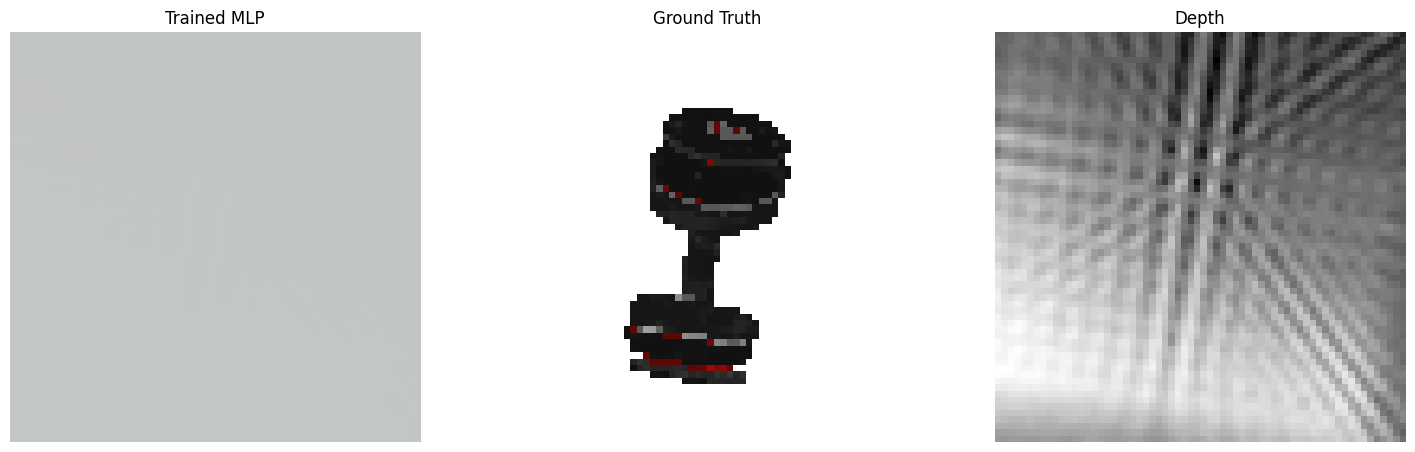

Step 100: loss = 0.03037


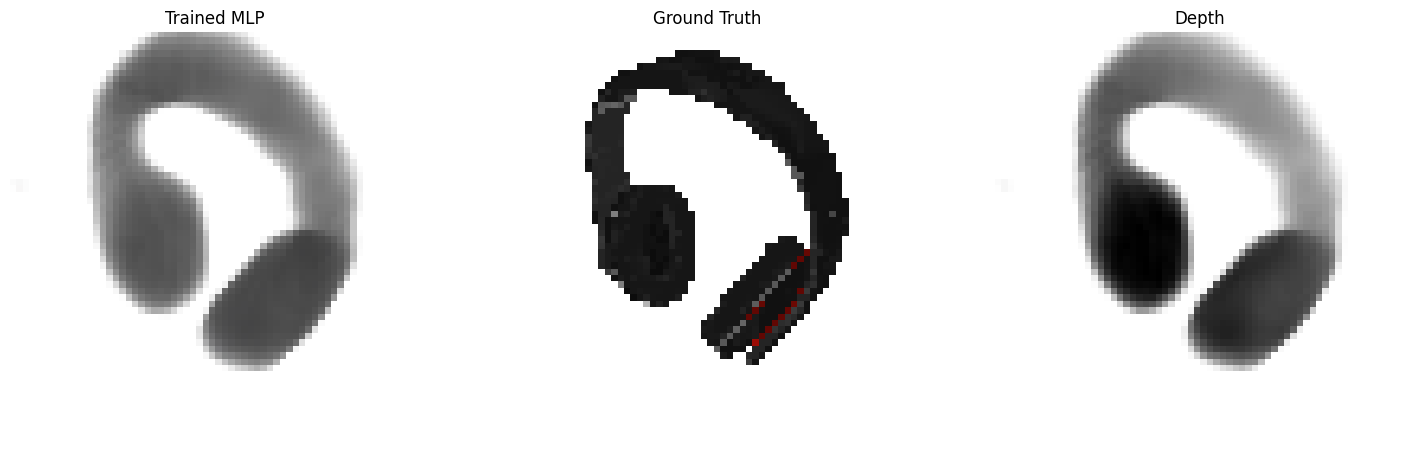

Step 200: loss = 0.02045


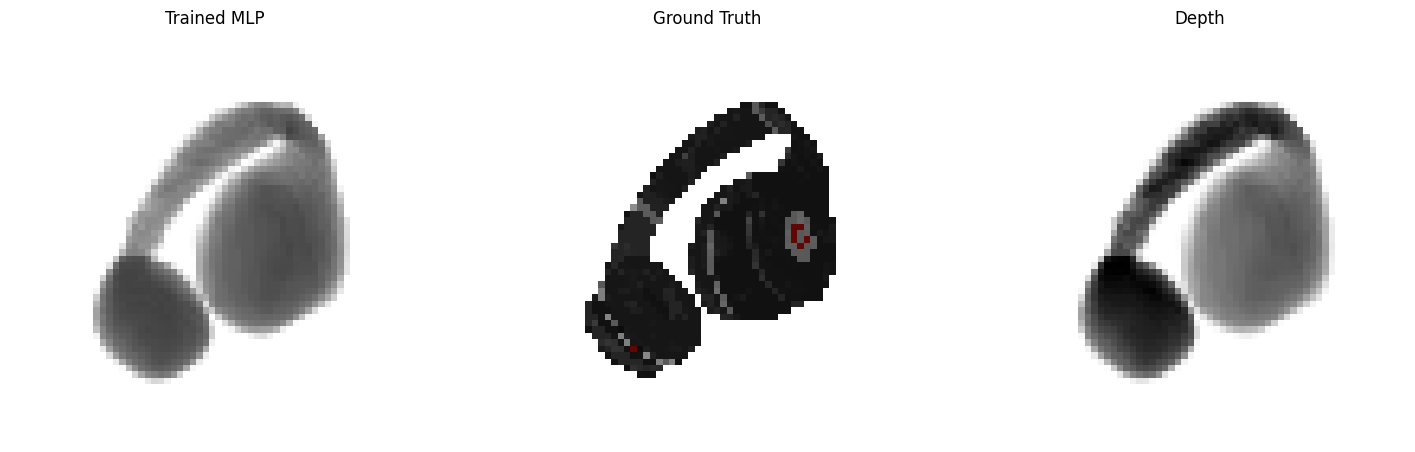

Step 300: loss = 0.02826


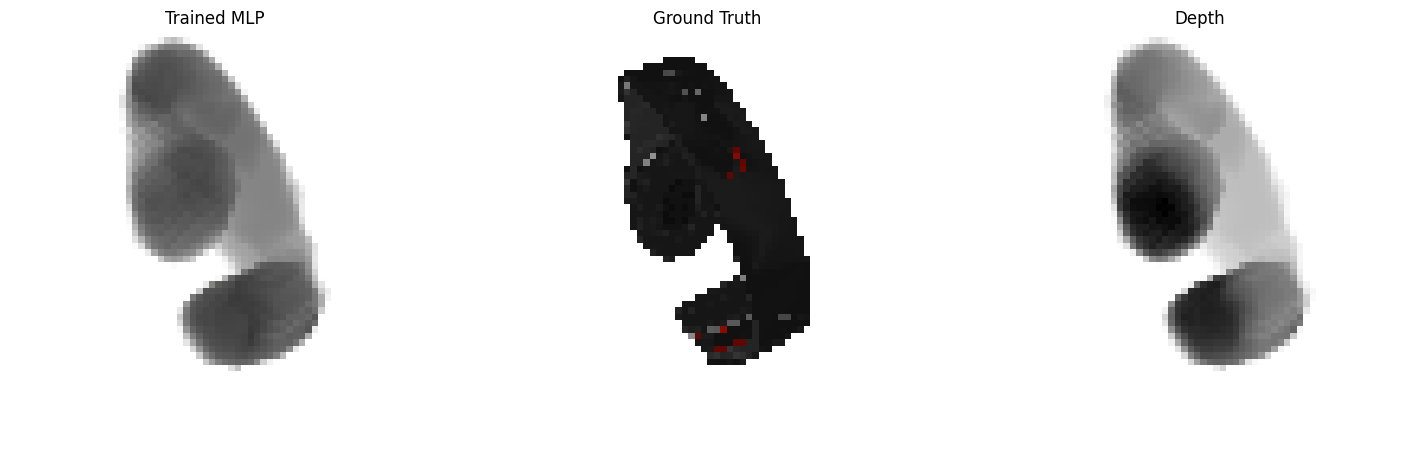

Step 400: loss = 0.02508


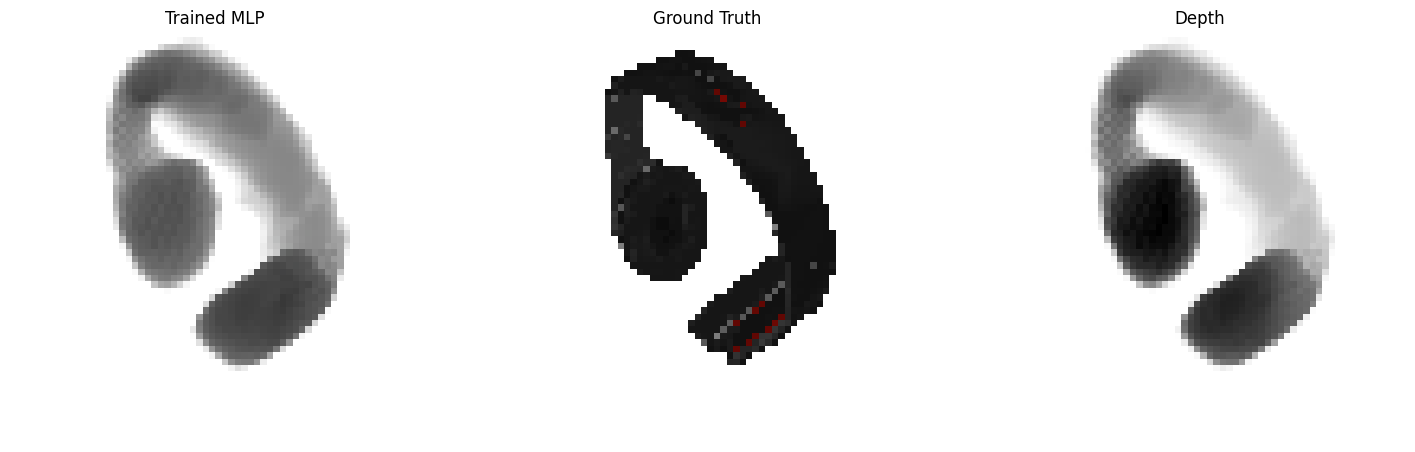

Step 500: loss = 0.03148


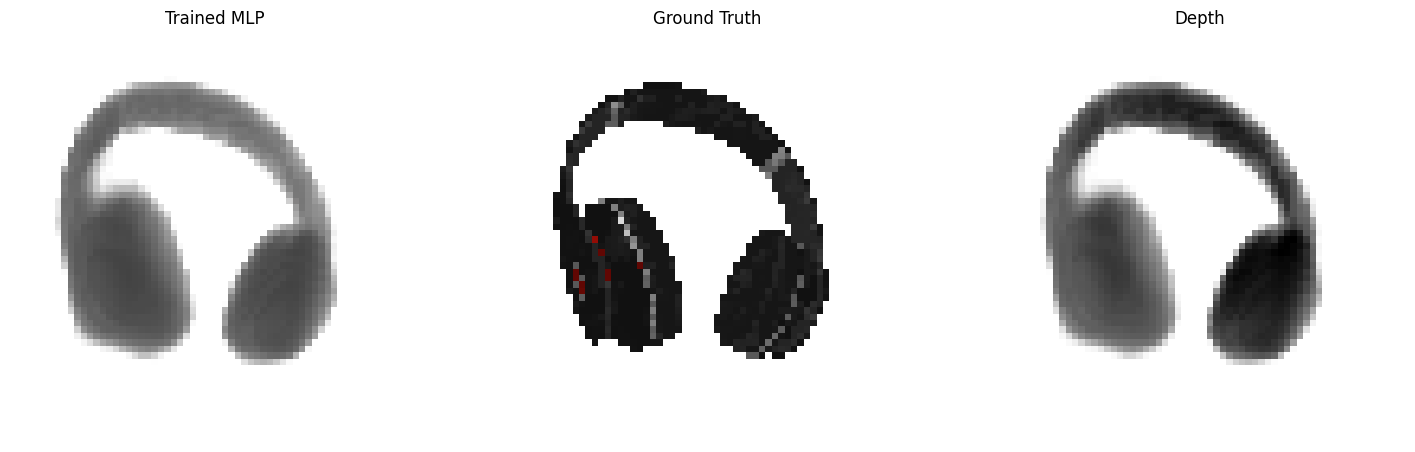

Step 600: loss = 0.02763


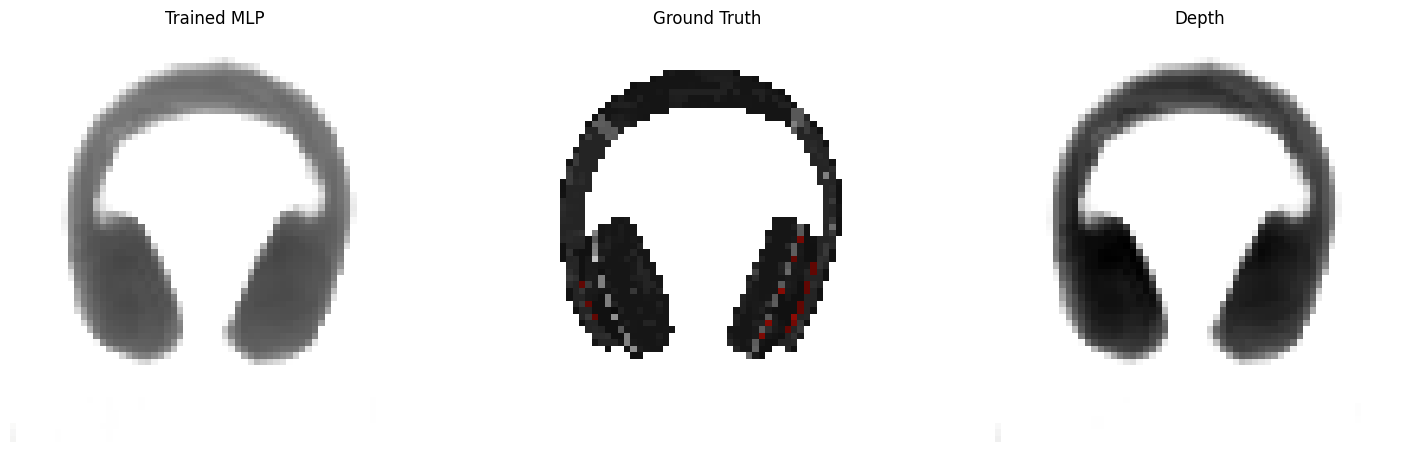

Step 700: loss = 0.02177


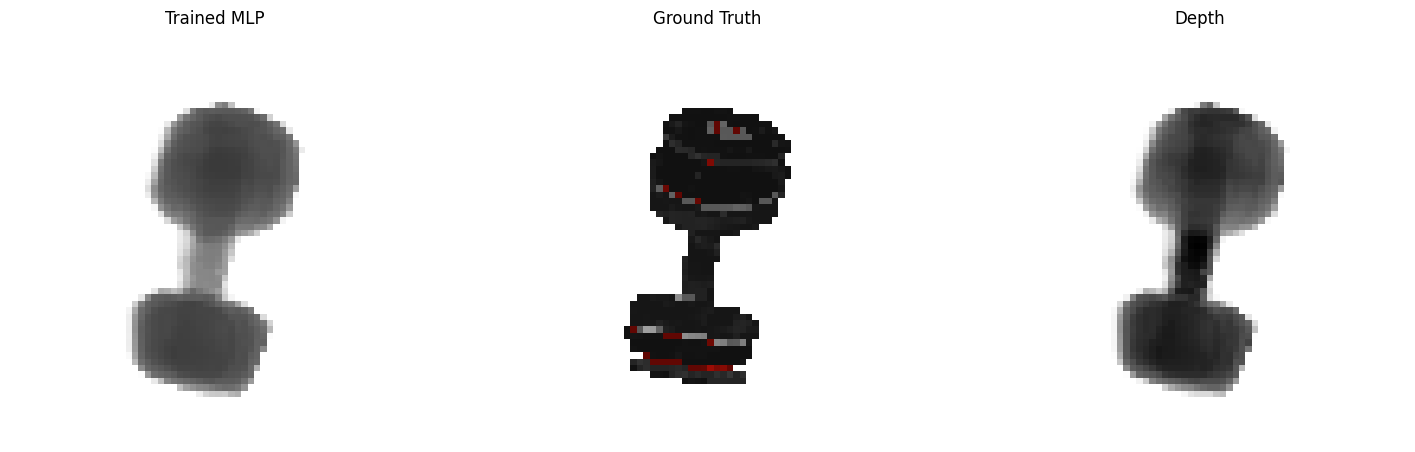

Step 800: loss = 0.02244


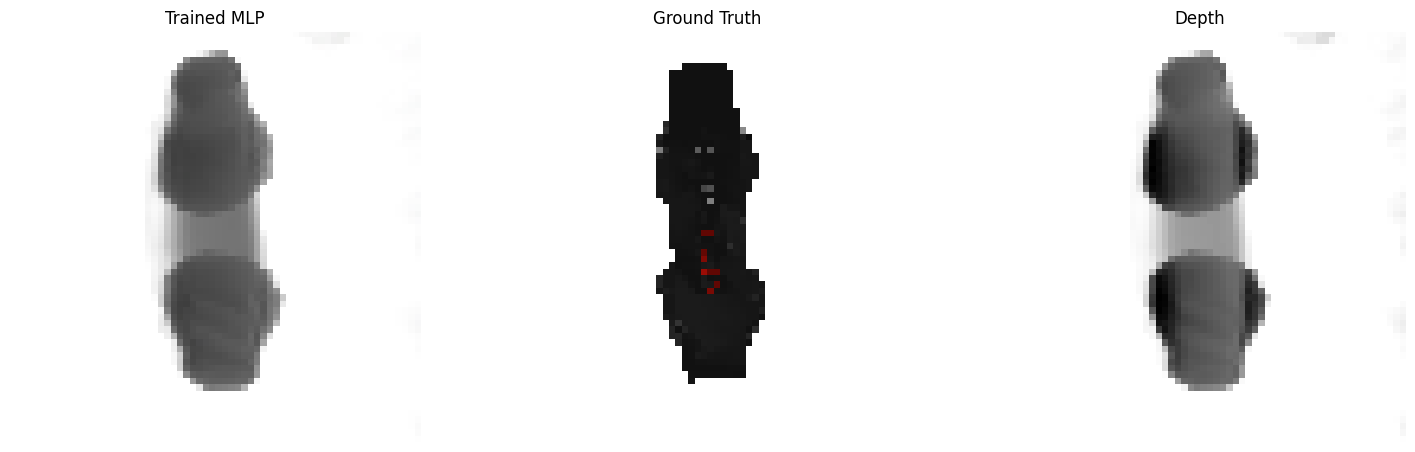

Step 900: loss = 0.02356


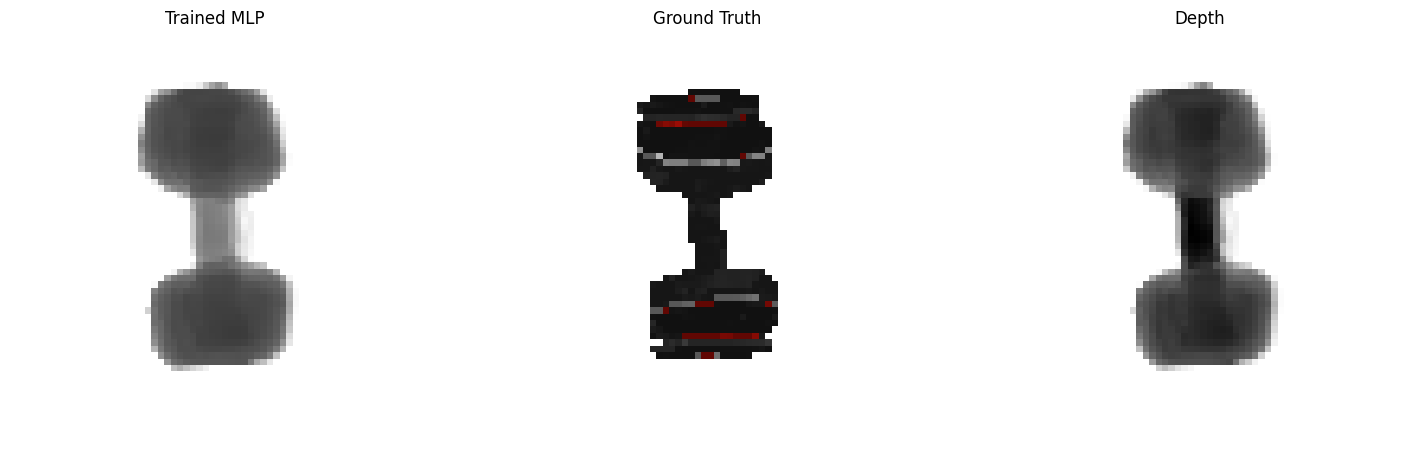

Step 1000: loss = 0.02252


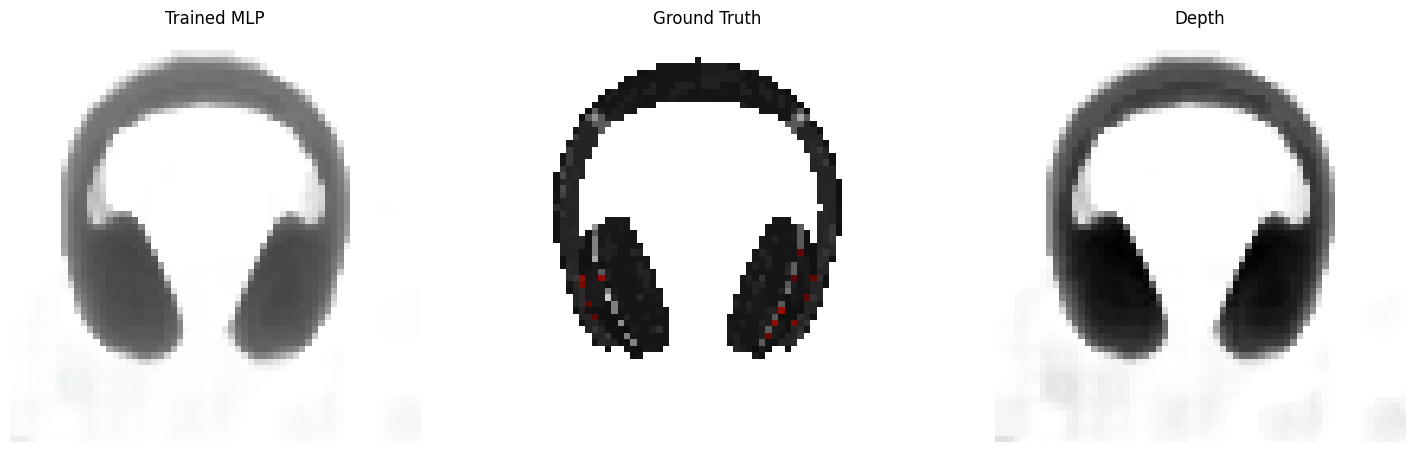

In [ ]:
### MIGHT HAVE TO RUN MULTIPLE TIMES FOR FUNCTIONAL INITIALIZATION ###

img_sl = 64
dataset = ShapeNetIterableDataset(path, synset_id='03261776', model_id='937cdf200b33bdfd1aec2282dd8bc87a', img_sidelength=img_sl)
data_loader = DataLoader(dataset, batch_size=4)
rf_and_renderer = RadianceFieldRenderer().cuda()
optim = torch.optim.Adam(lr=1e-3, params=rf_and_renderer.parameters())

_ = fit(rf_and_renderer,
        iter(data_loader),
        loss_fn=mse_loss,
        resolution=(img_sl, img_sl, 3),
        plotting_function=plot_output_ground_truth,
        optimizer=optim,
        total_steps=1001,
        steps_til_summary=100
        )

In [ ]:
del rf_and_renderer

# Autodecoder

In [ ]:
class AutoDecoder(nn.Module):
    def __init__(
        self,
        num_latents: int,
        submodule: nn.Module,
        param_name: str
    ):
        super().__init__()

        trgt_param = dict(submodule.named_parameters())[param_name]
        self.trgt_param_shape = trgt_param.shape[1:]
        self.latents = nn.Embedding(num_embeddings=num_latents,
                                    embedding_dim=np.prod(self.trgt_param_shape))
        self.latents.weight.data.normal_(0, 1e-1)
        self.param_name = param_name
        self.submodule = submodule

    def forward(self, inputs):

        latent_idcs = inputs['idx']
        batch_size = latent_idcs.shape[0]
        params = self.latents(latent_idcs).reshape(batch_size, *self.trgt_param_shape)
        param_dict = {self.param_name: params}
        output = functional_call(self.submodule, param_dict, inputs)
        return output, params


In [ ]:
def autodecoder_loss(mlp_out, gt, model):

    (img, depth), latents = mlp_out
    img_loss = ((img - gt)**2).mean()
    latent_loss = (latents**2).mean()
    param_loss = 0.

    for name, param in model.named_parameters():
        if 'latent' not in name:
            param_loss += (param**2).mean()

    return param_loss*1e-4 + latent_loss*1e-4 + img_loss

In [ ]:
def plot_output_ground_truth(model_output, ground_truth, resolution):
    (img_batch, depth_batch), latent = model_output

    num_batch_items = 4
    fig, axes = plt.subplots(num_batch_items, 3, figsize=(18, 6*num_batch_items), squeeze=False)

    for i in range(num_batch_items):
        img = img_batch[i]
        depth = depth_batch[i]
        gt = ground_truth[i]

        axes[i, 0].imshow(img.cpu().view(*resolution).detach().numpy())
        axes[i, 0].set_title("Trained MLP")
        axes[i, 1].imshow(gt.cpu().view(*resolution).detach().numpy())
        axes[i, 1].set_title("Ground Truth")

        depth = depth.cpu().view(*resolution[:2]).detach().numpy()
        axes[i, 2].imshow(depth, cmap='Greys')
        axes[i, 2].set_title("Depth")

        for j in range(3):
            axes[i, j].set_axis_off()

    plt.show()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

Step 0: loss = 0.08162


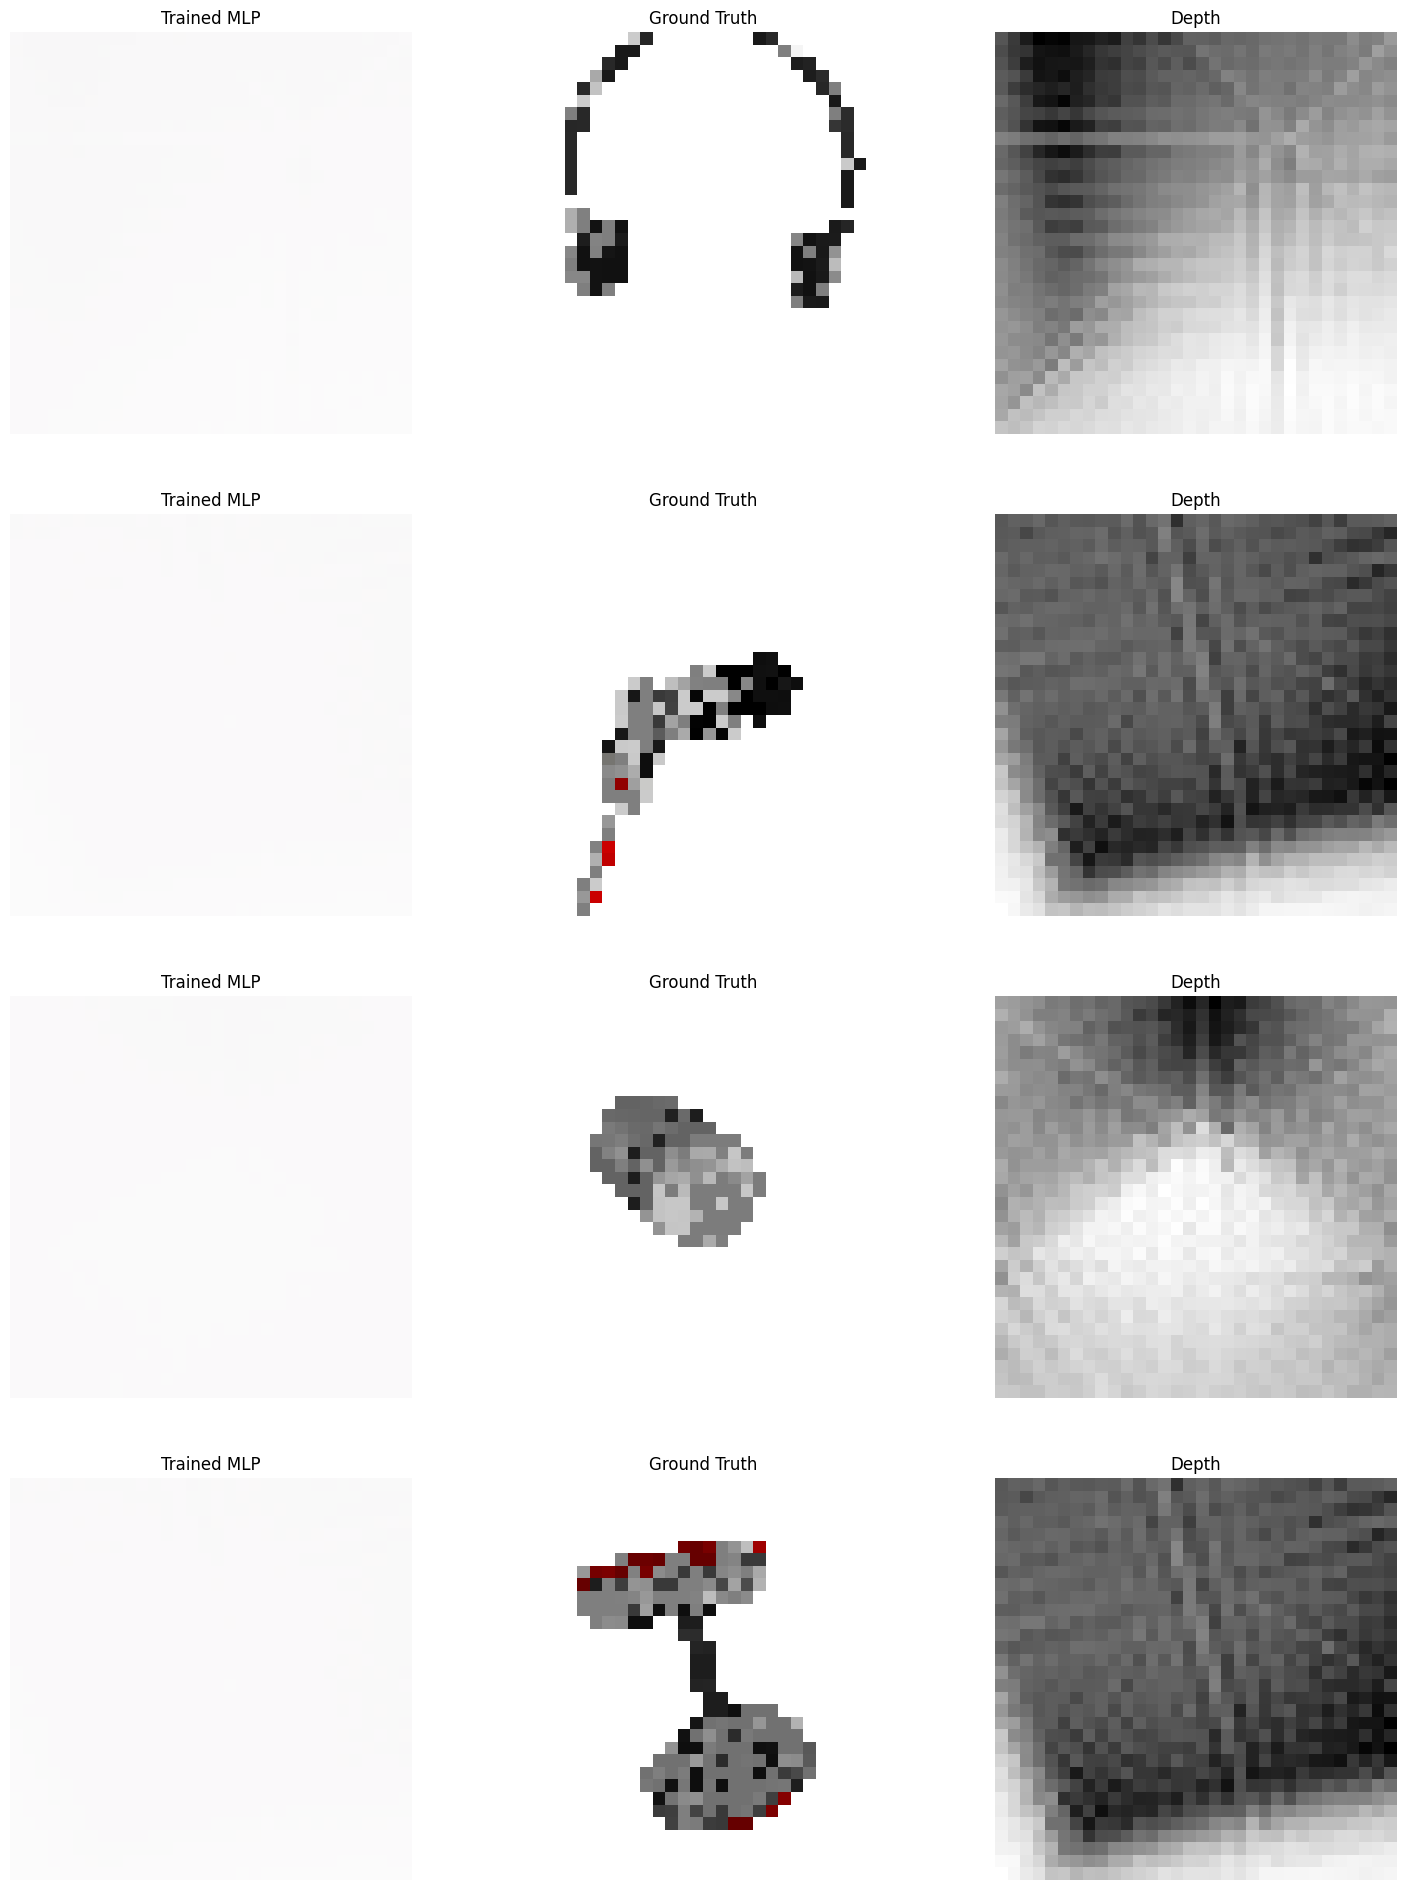

Step 1000: loss = 0.01981


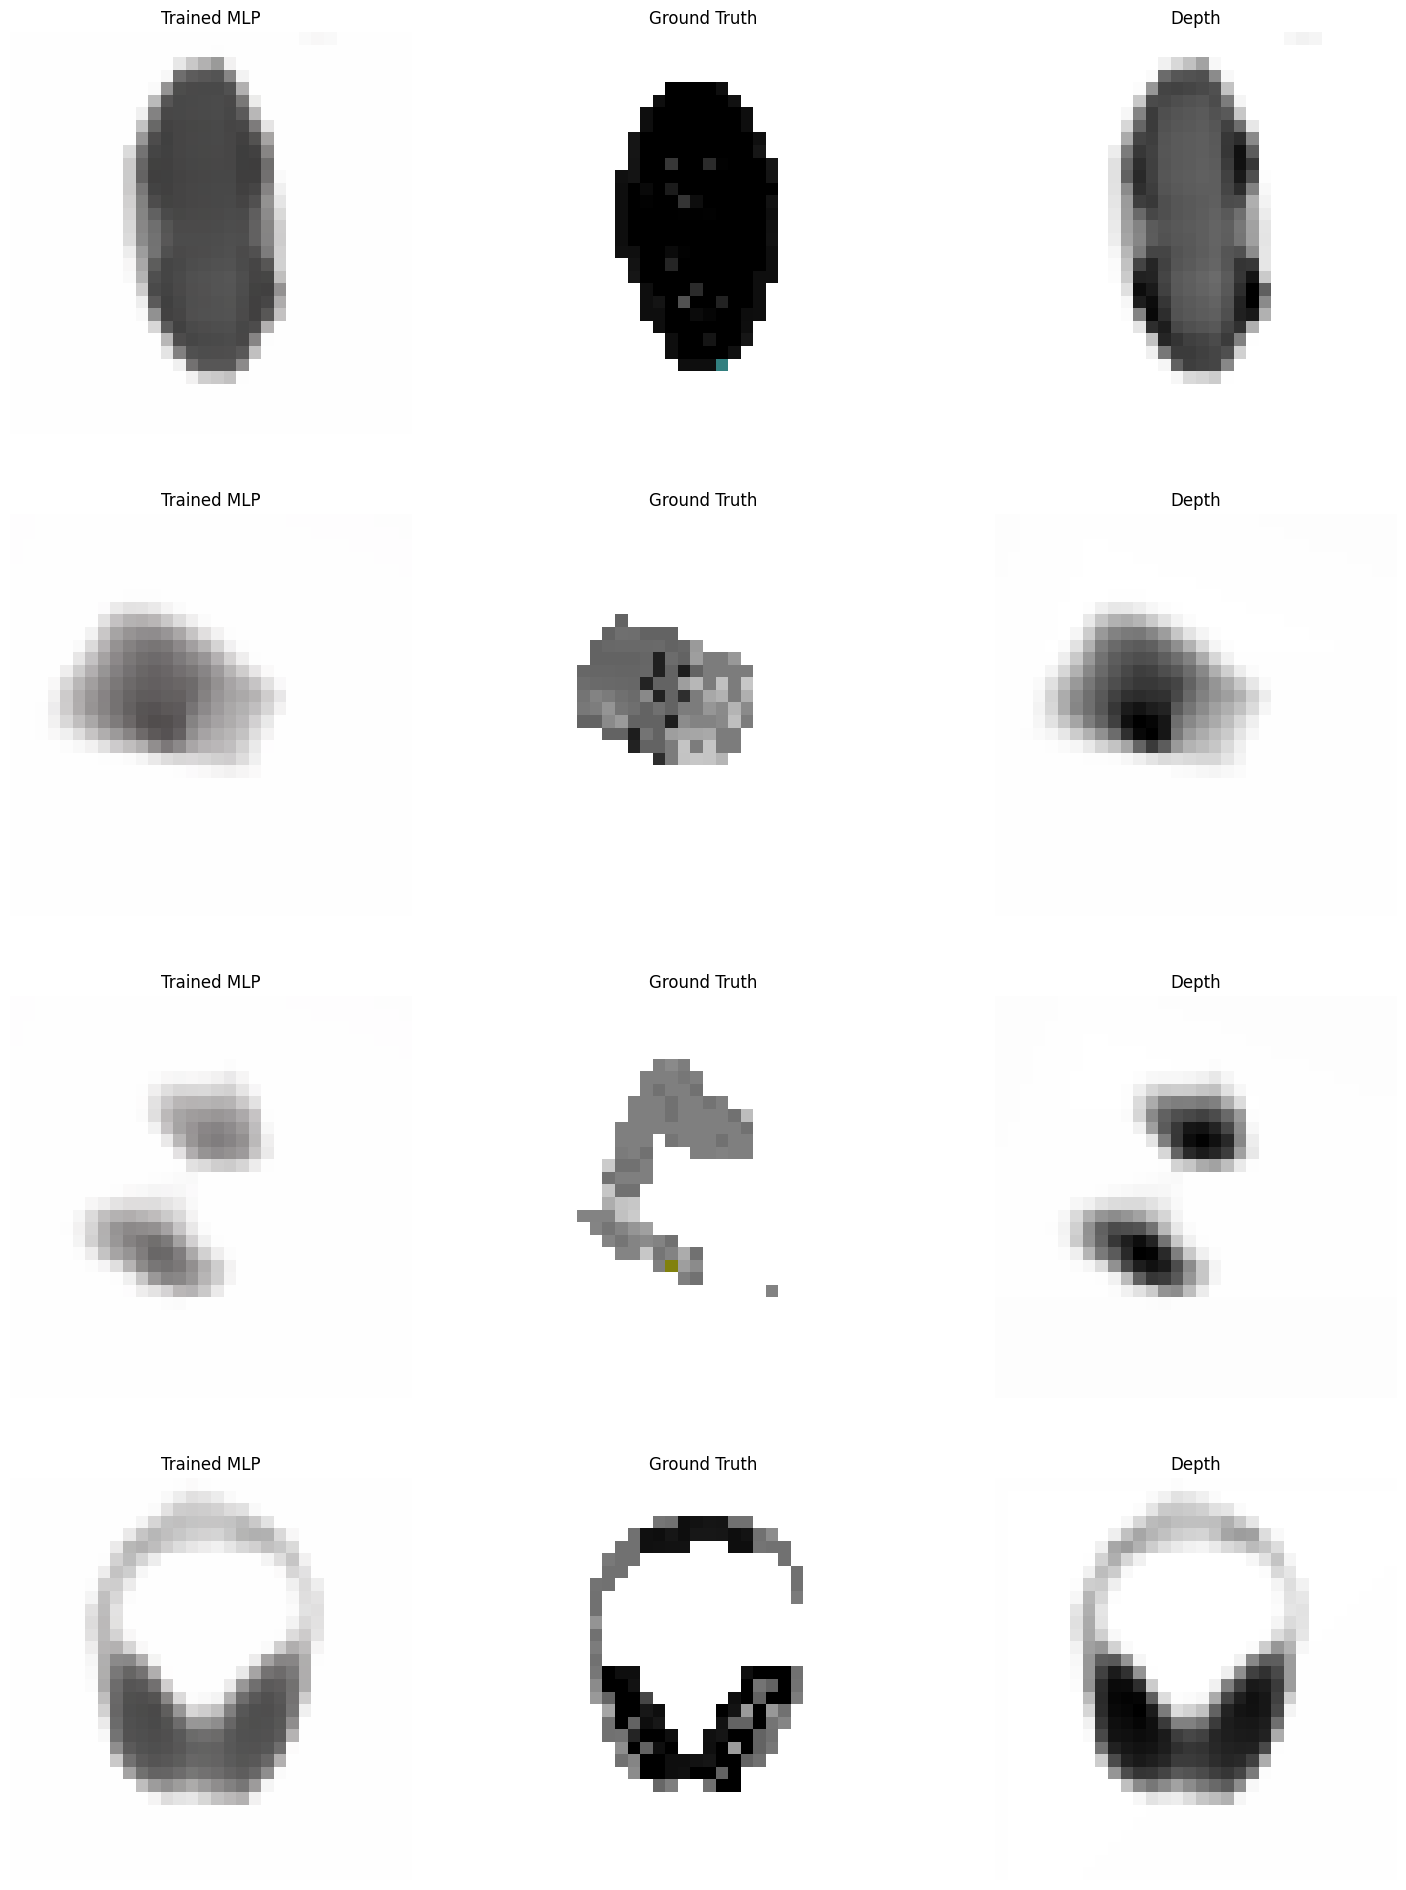

Step 2000: loss = 0.01887


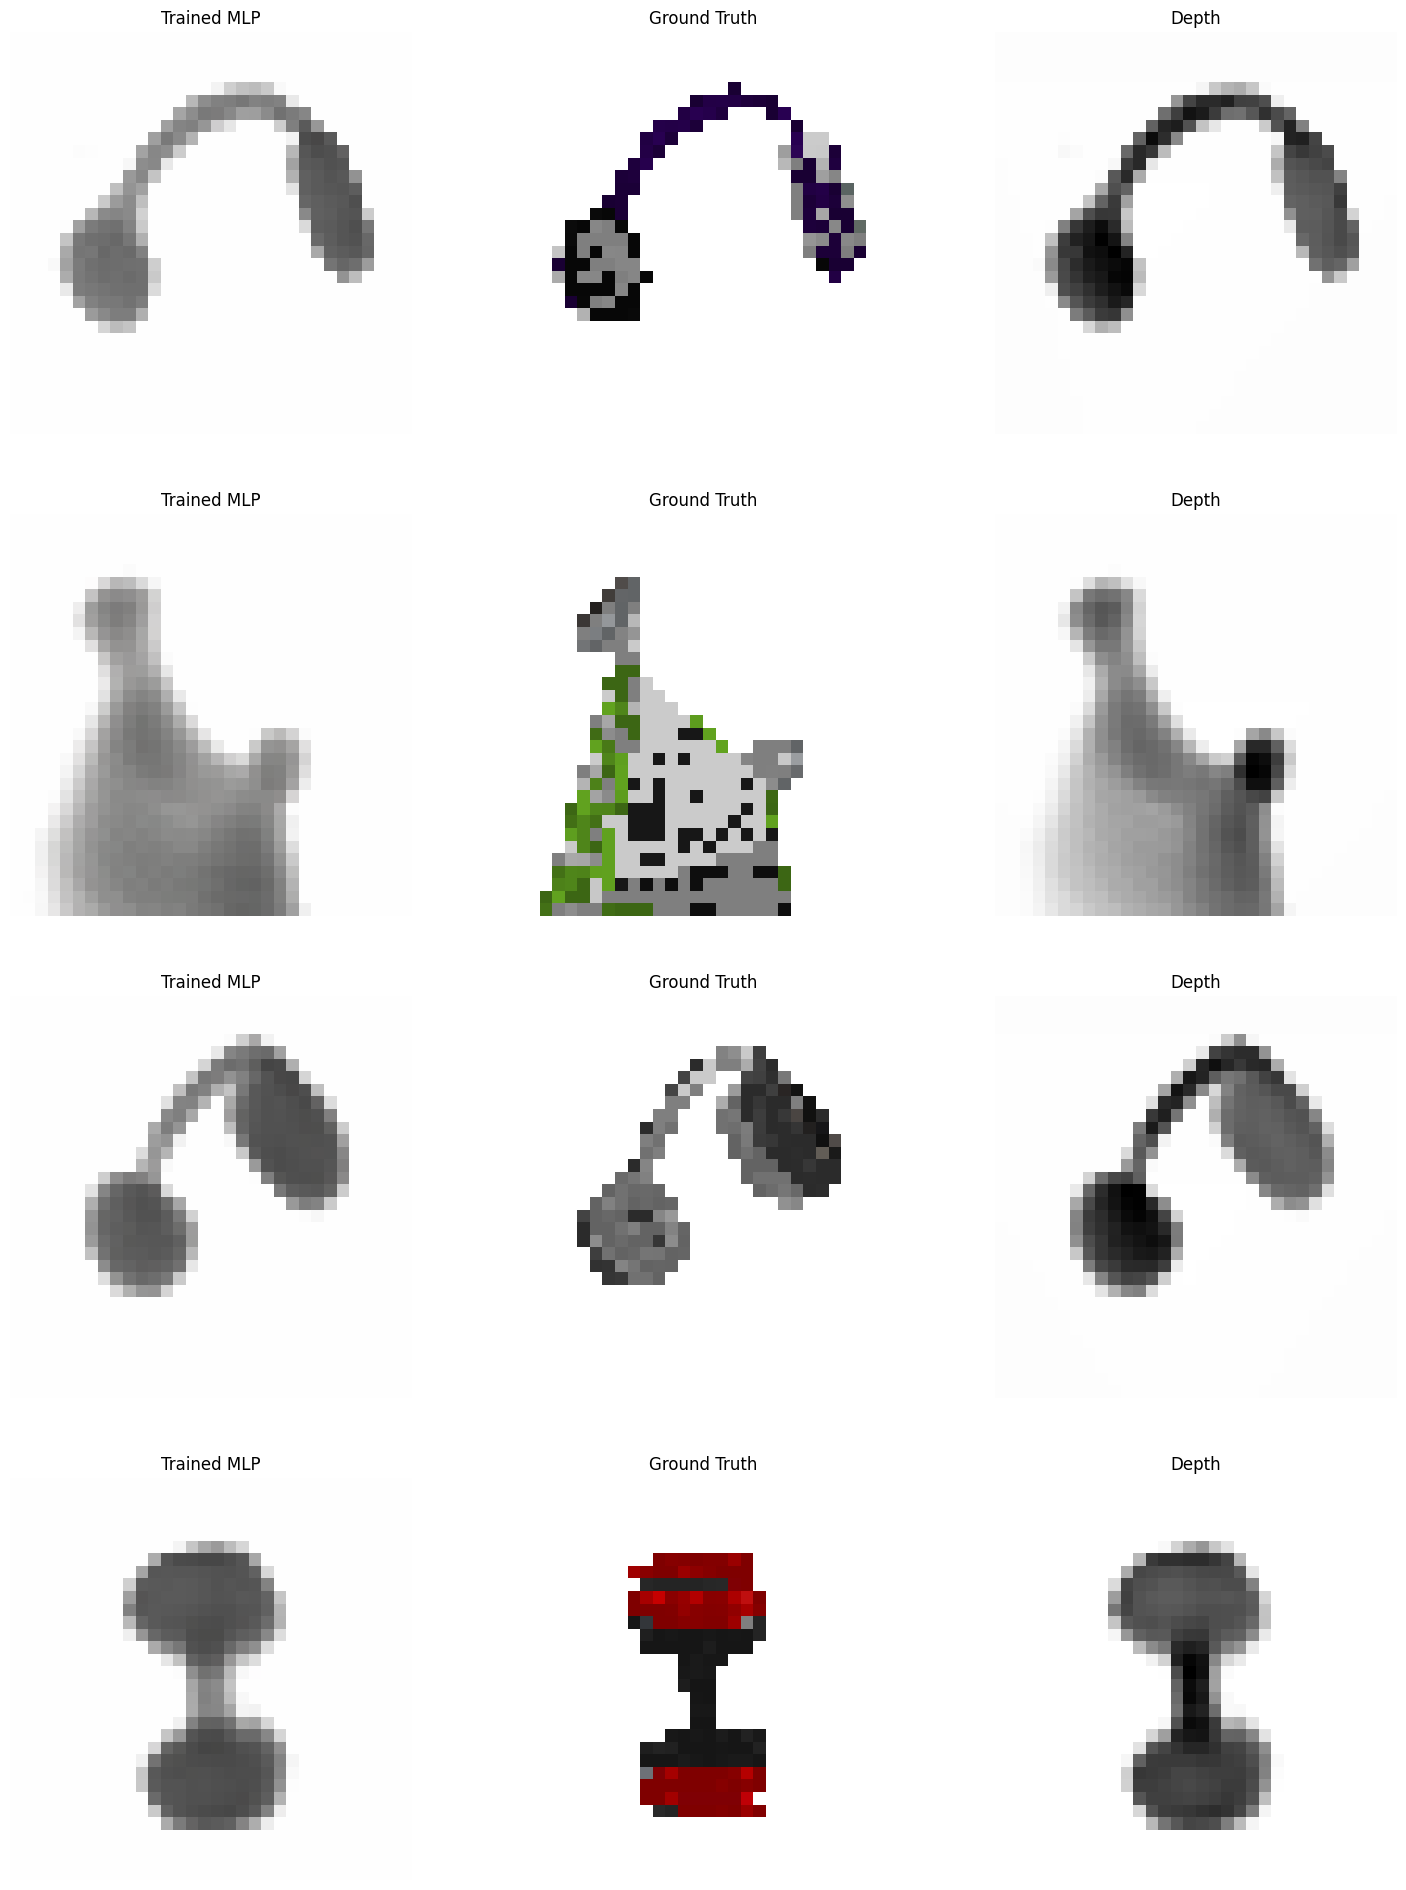

Step 3000: loss = 0.01738


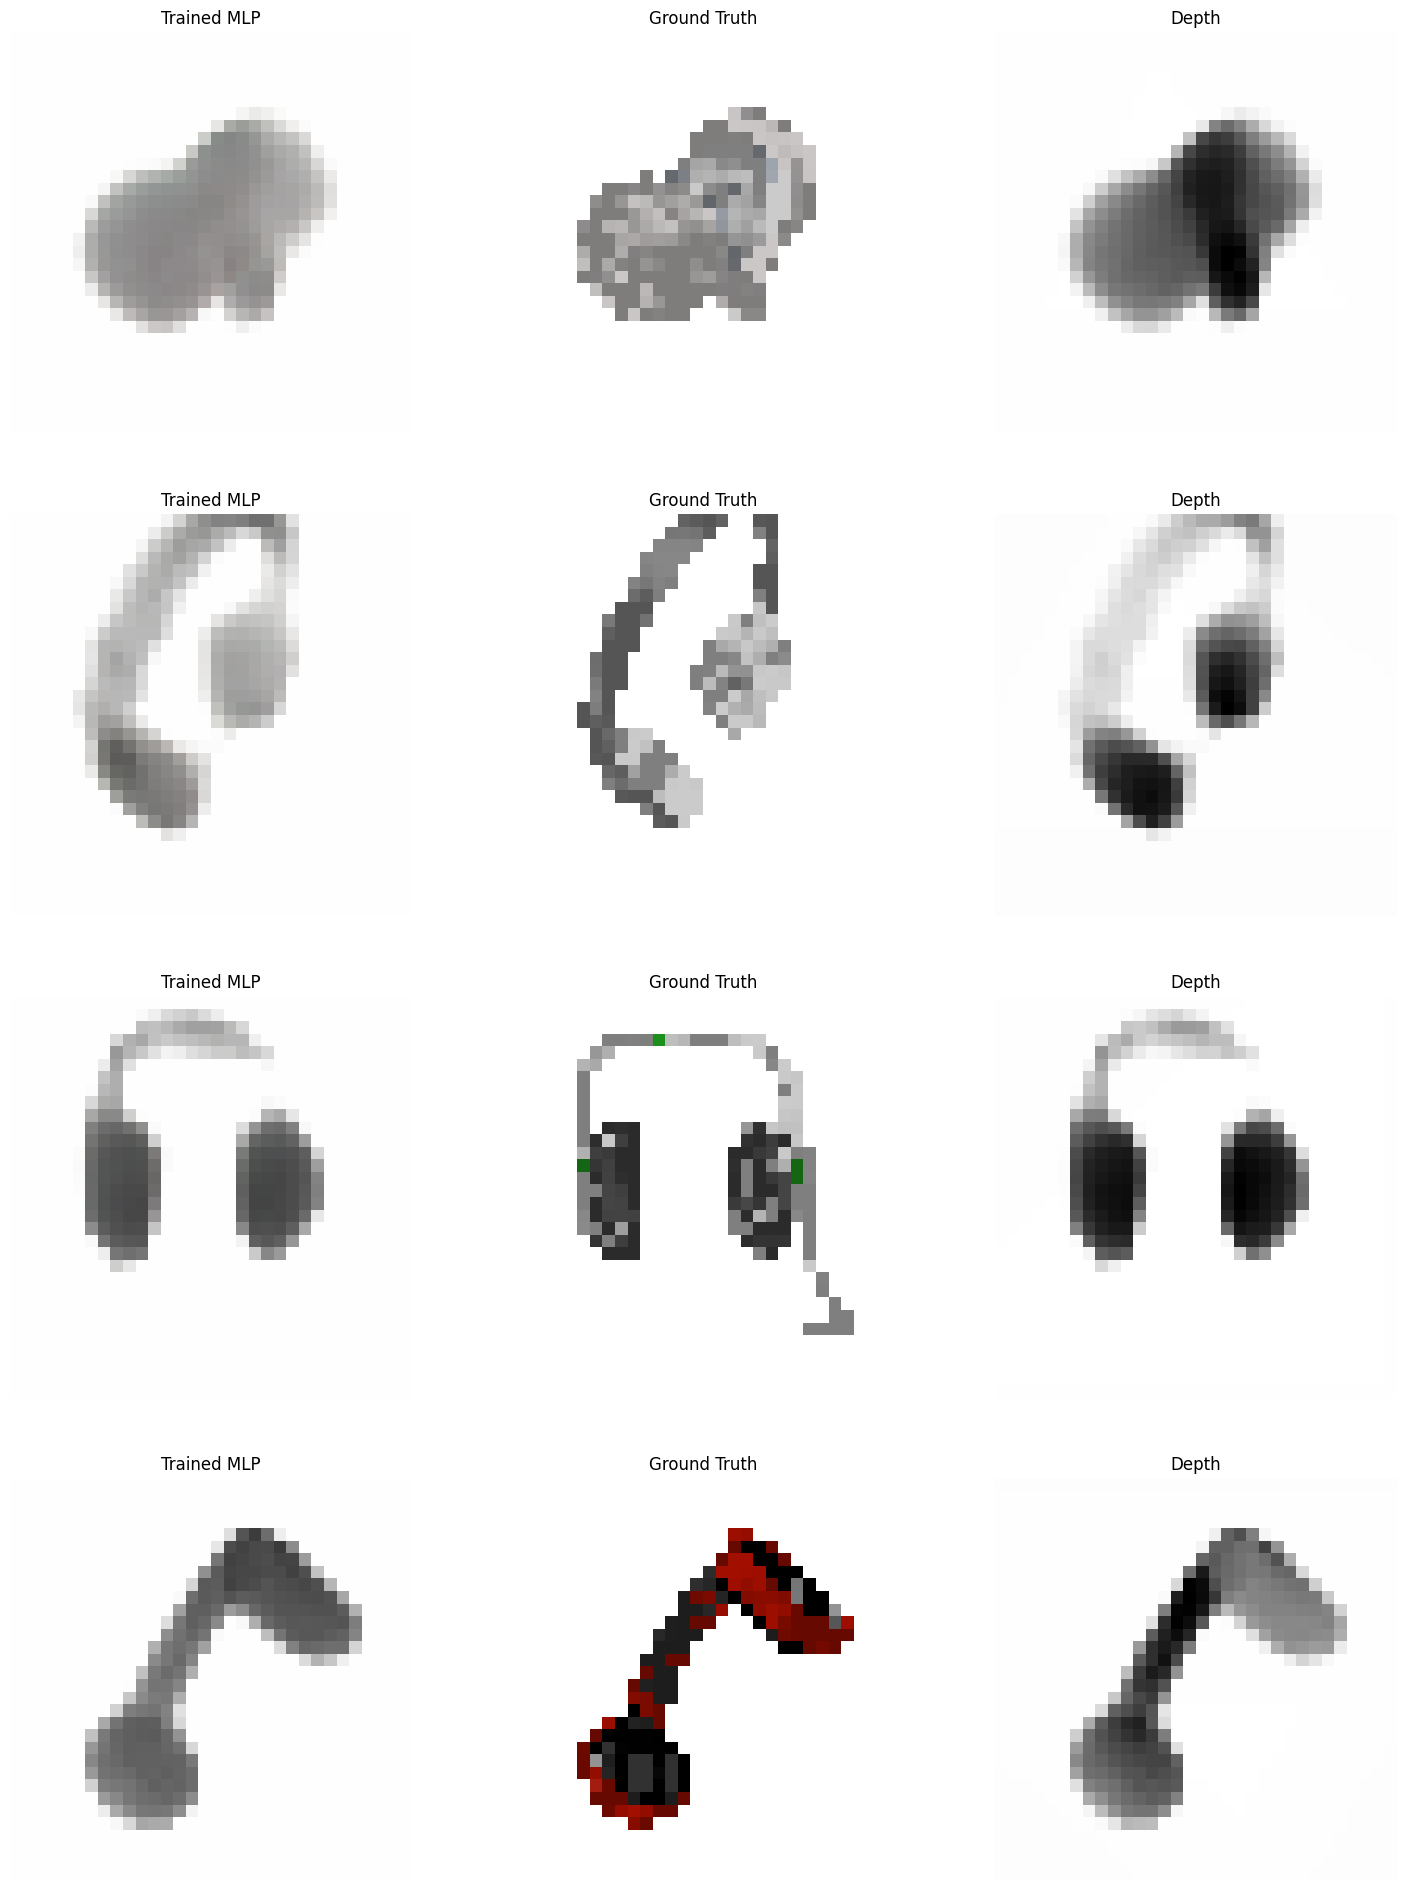

Step 4000: loss = 0.01808


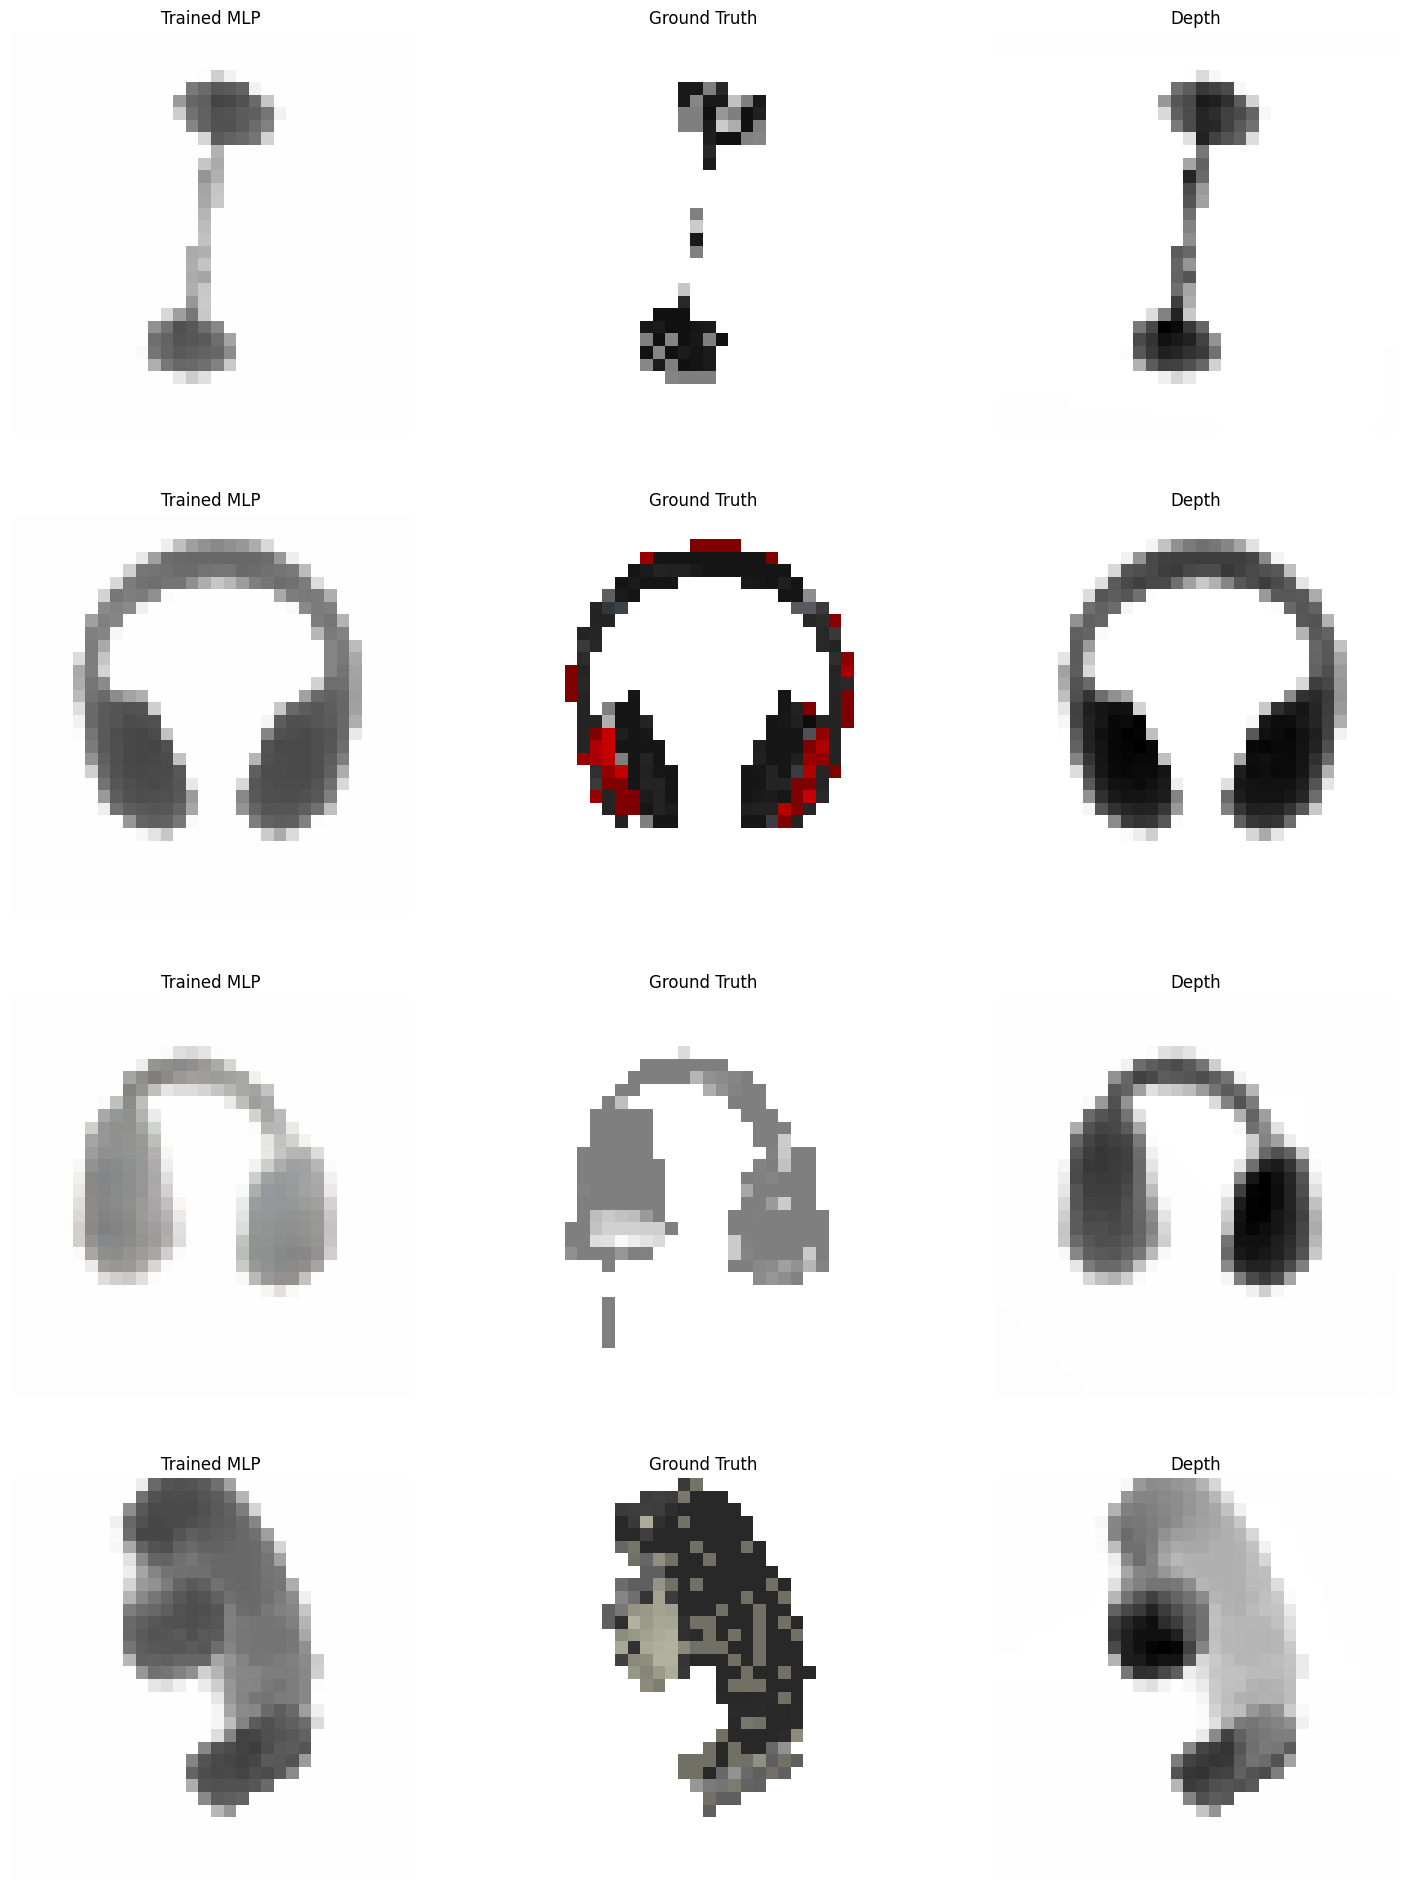

Step 5000: loss = 0.01551


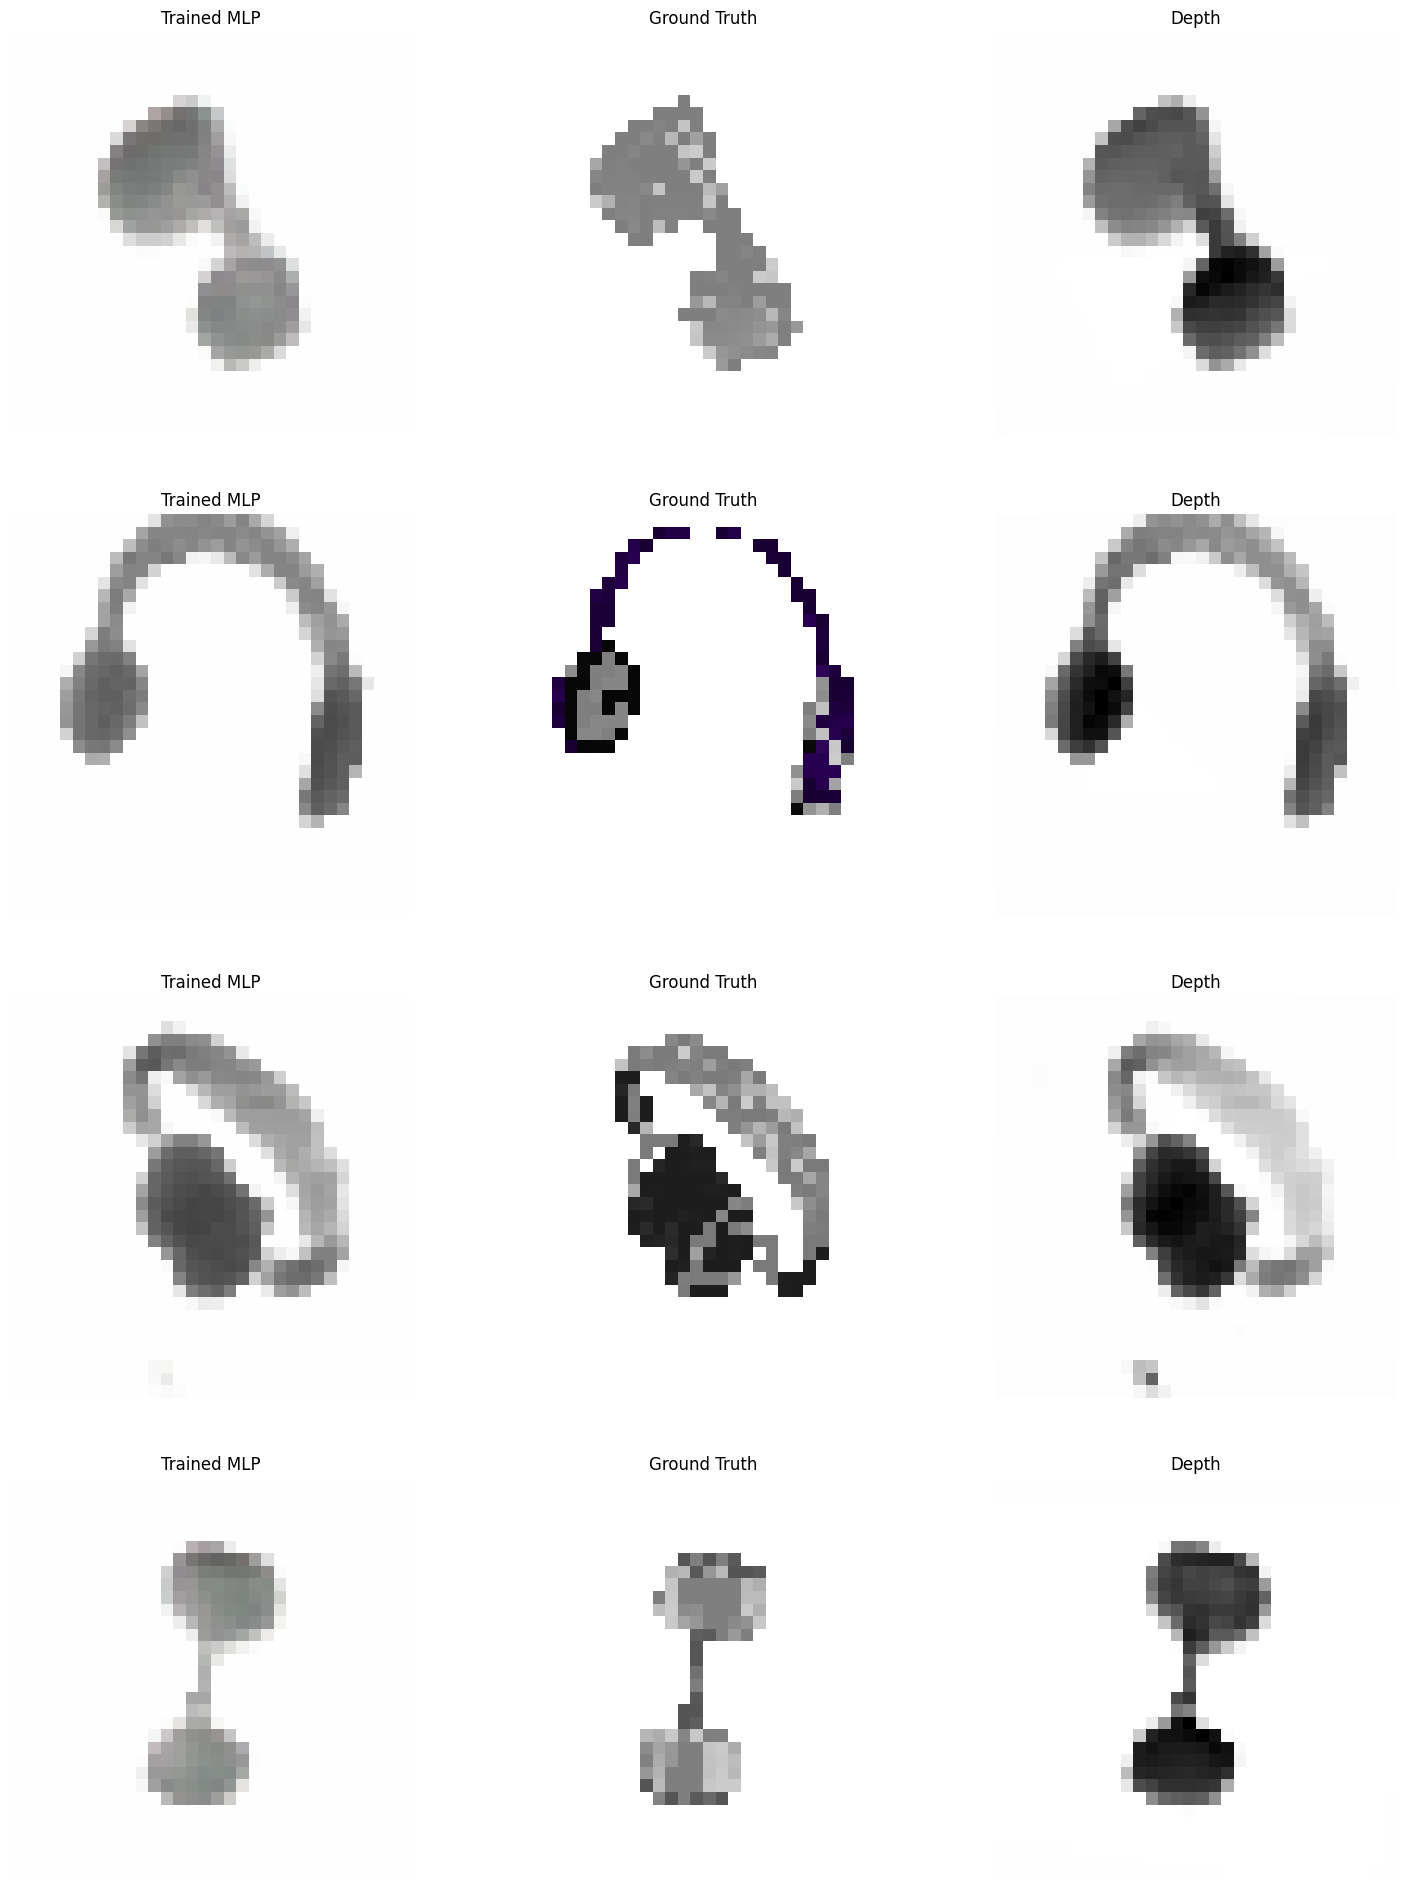

Step 6000: loss = 0.01803


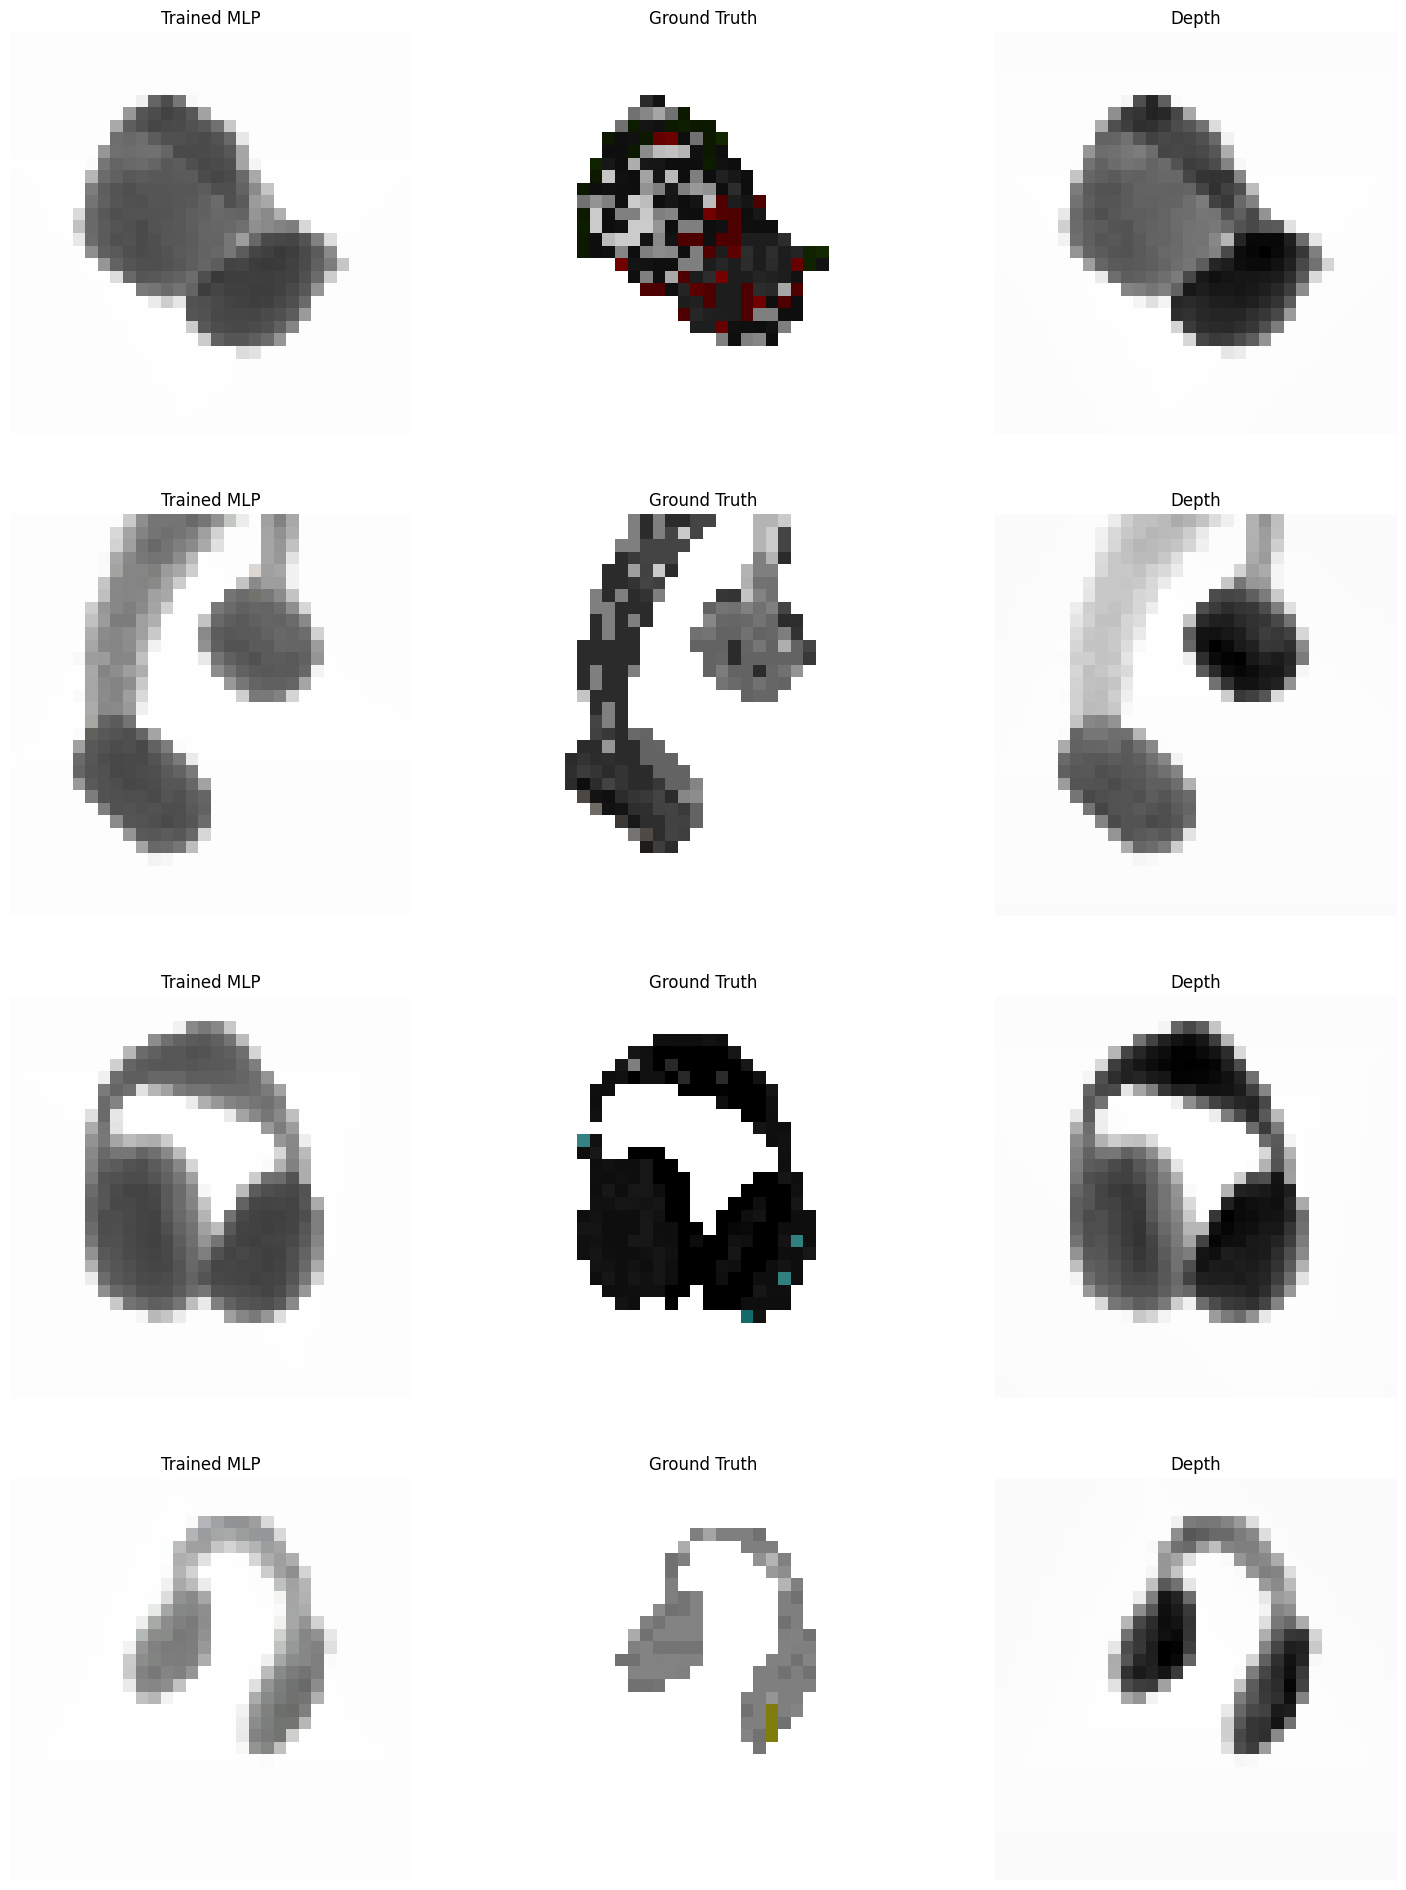

Step 7000: loss = 0.01676


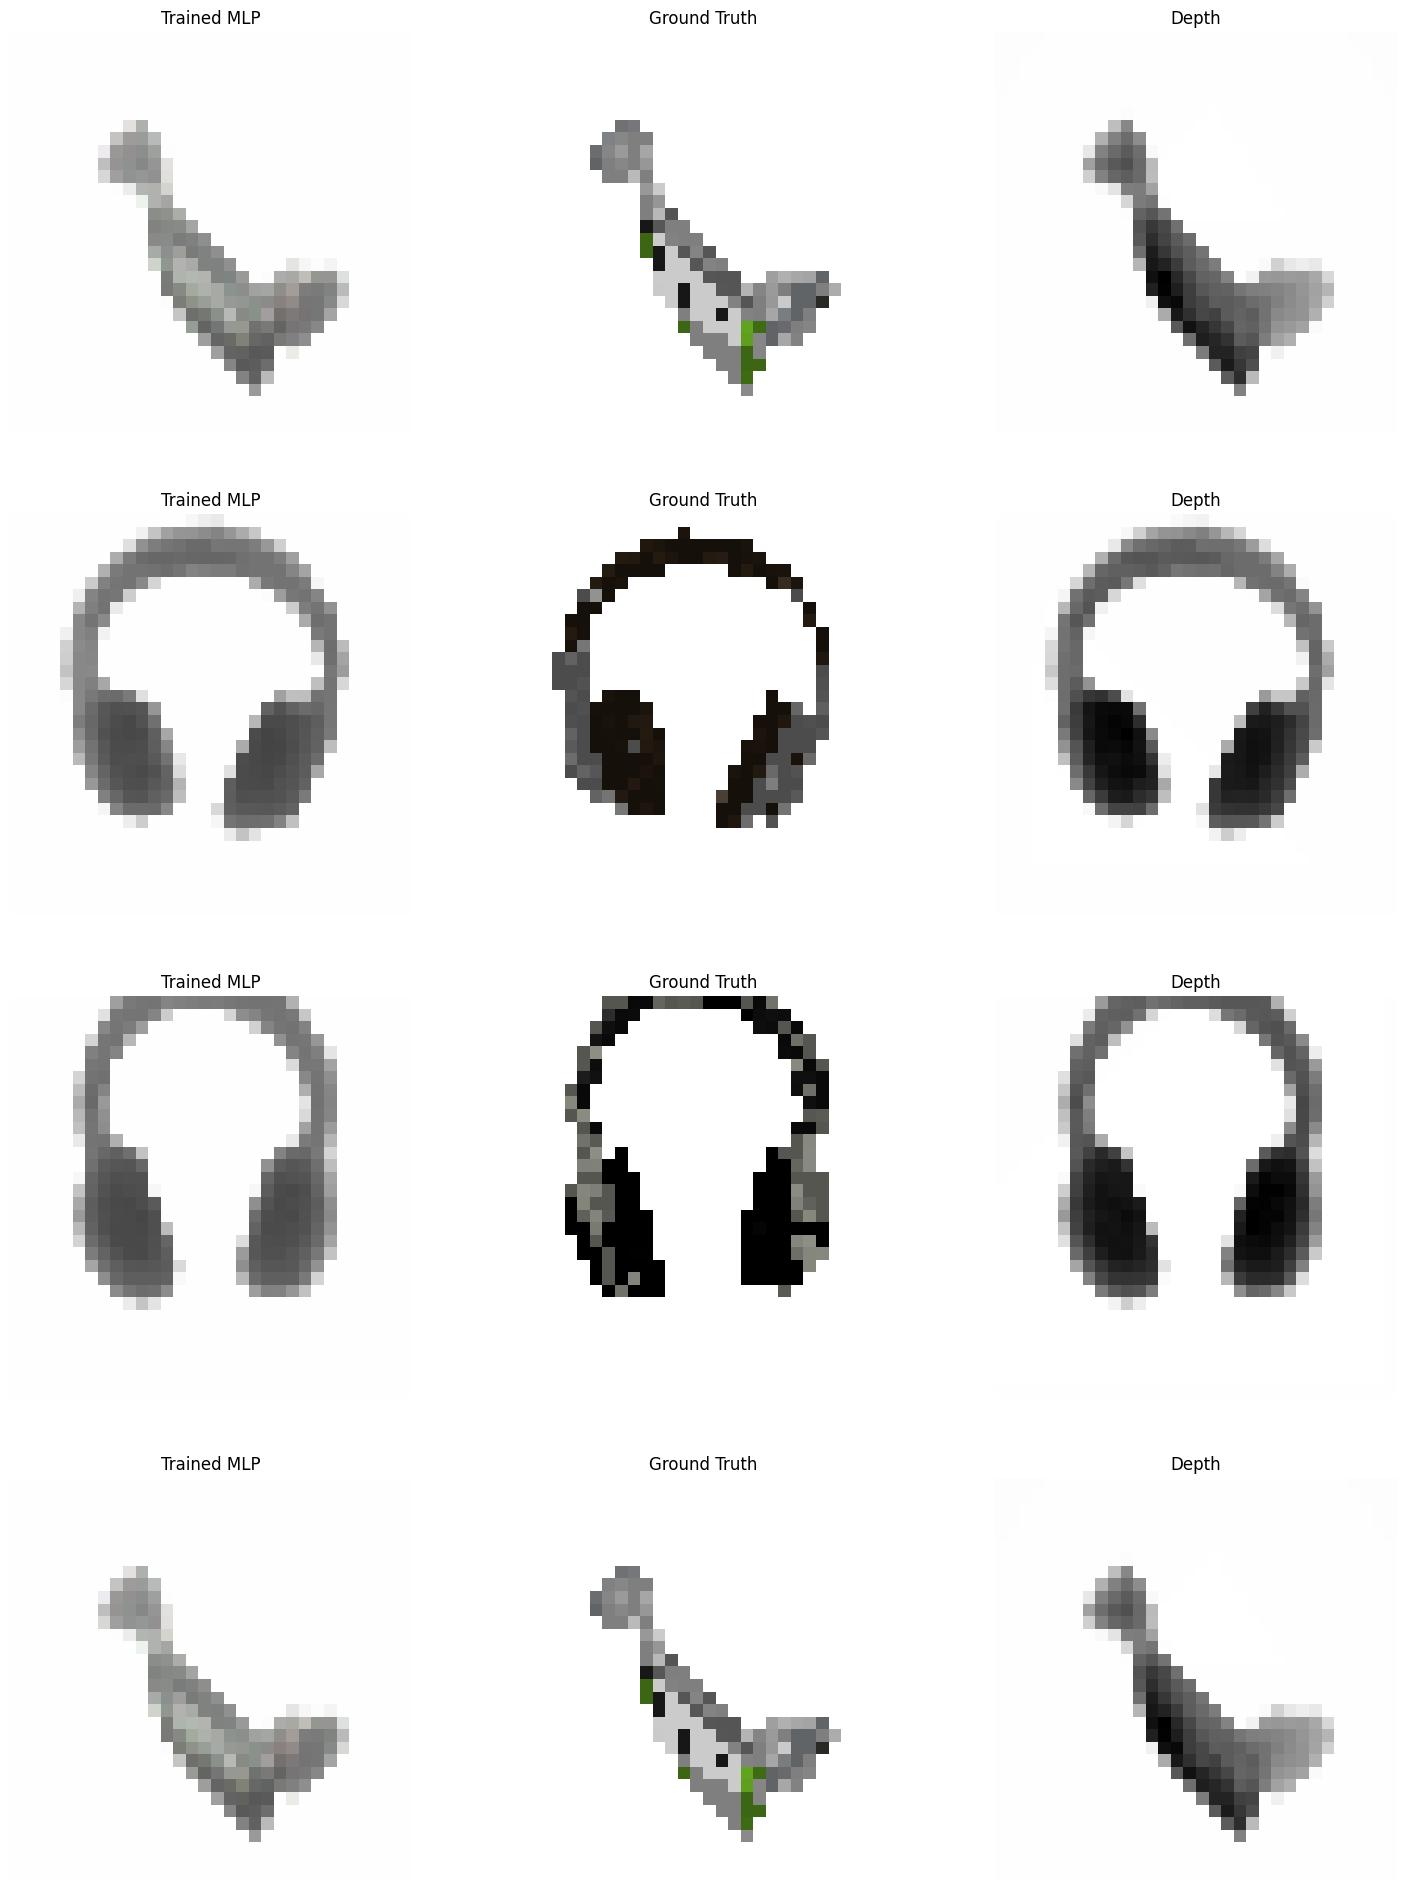

Step 8000: loss = 0.01602


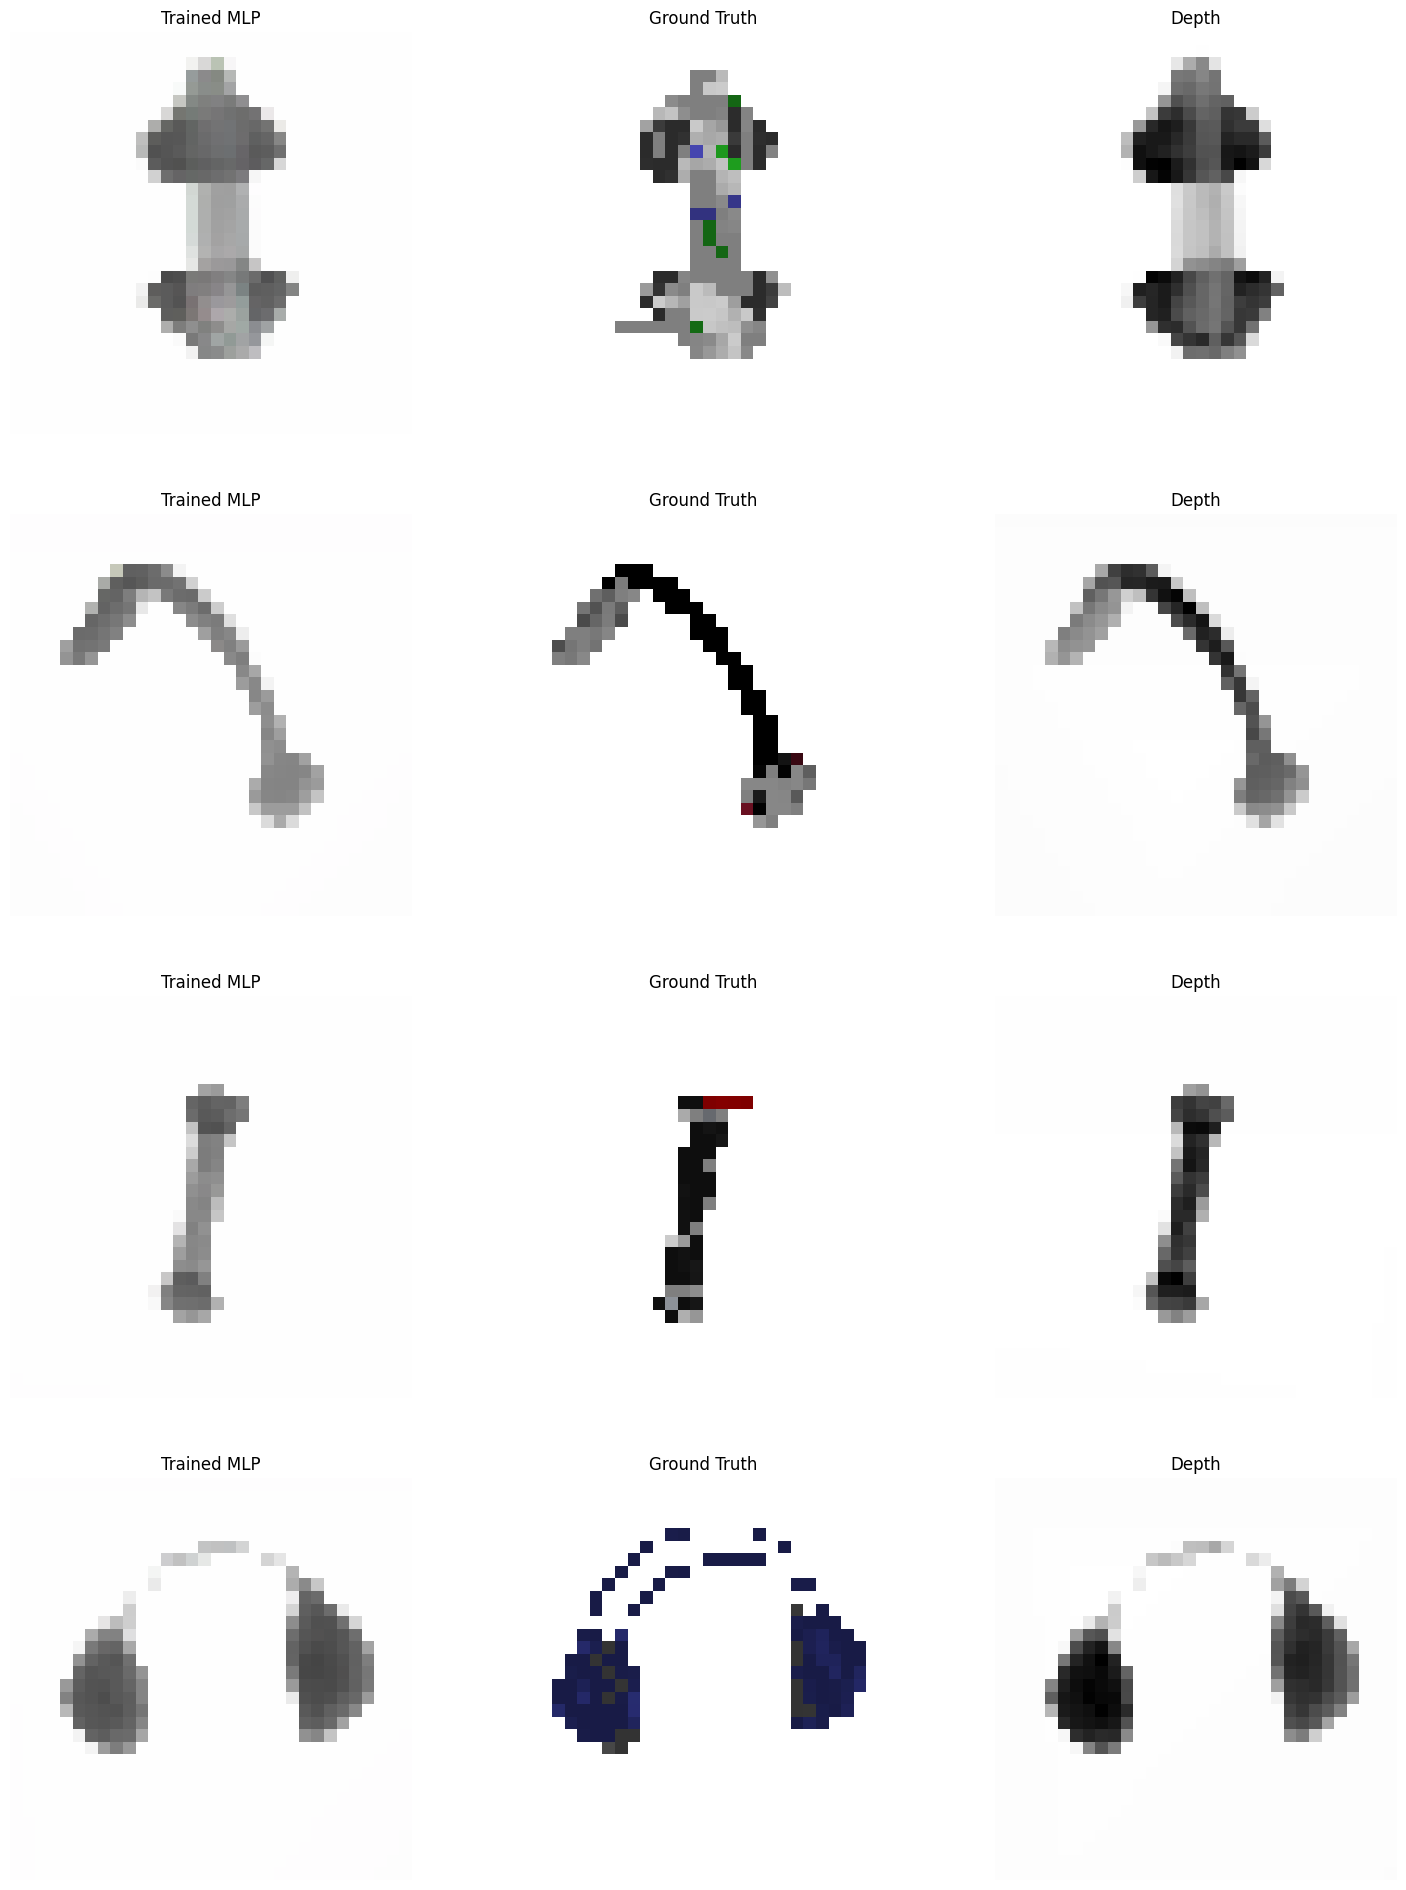

Step 9000: loss = 0.00980


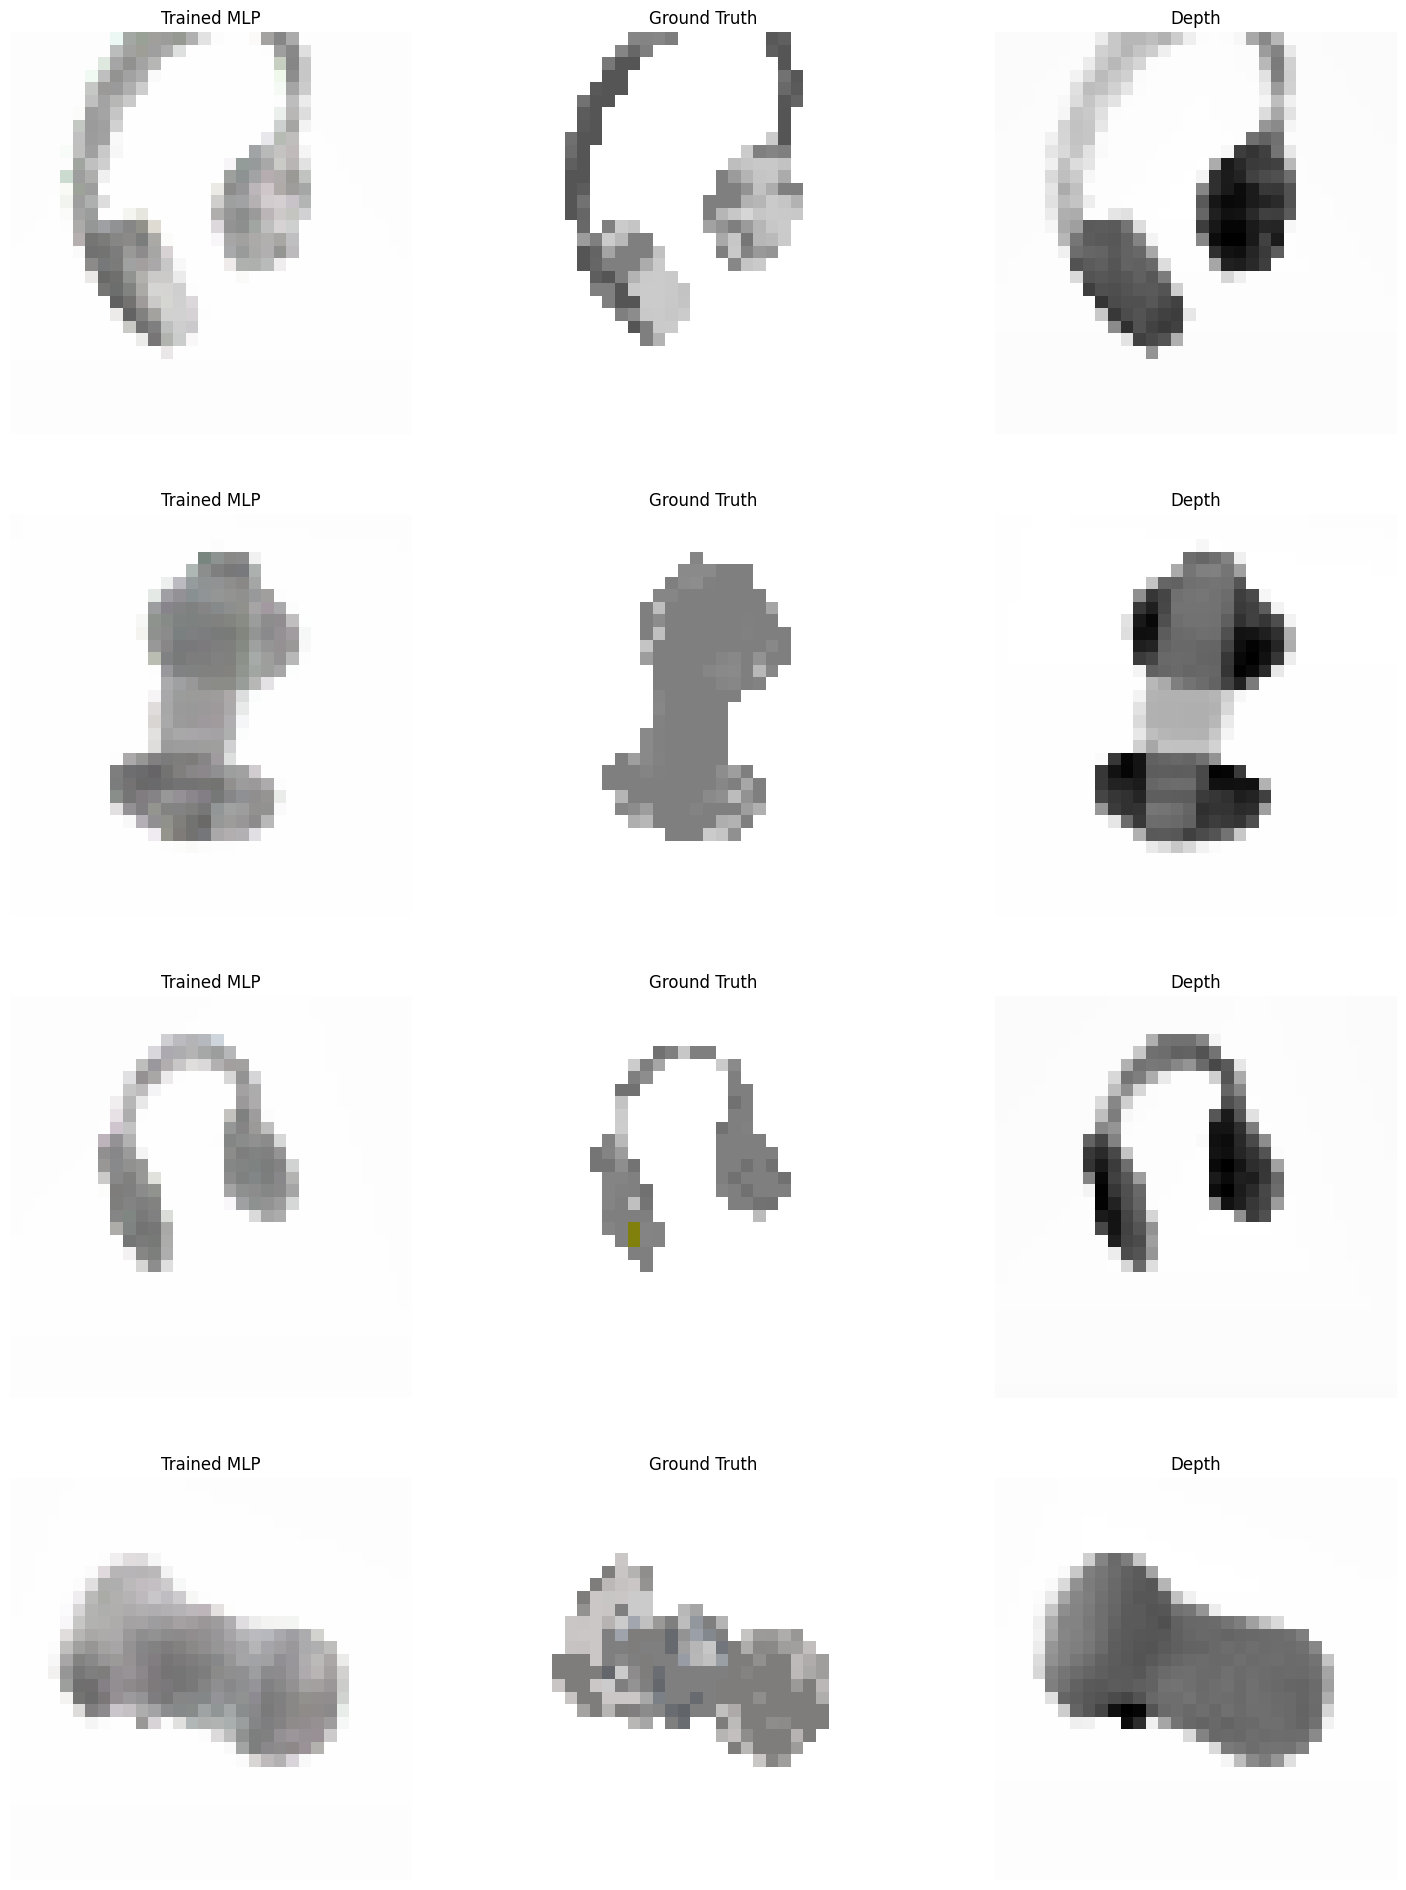

RuntimeError: ignored

In [ ]:
### MIGHT HAVE TO RUN MULTIPLE TIMES FOR FUNCTIONAL INITIALIZATION ###

img_sl = 32
num_scenes = 72
batch_size = 32

def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

dataset = ShapeNetIterableDataset(path, synset_id='03261776', max_num_instances=30, img_sidelength=img_sl)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, worker_init_fn=worker_init_fn)
srn_rf = RadianceFieldRenderer()
srns_ad = AutoDecoder(num_latents=num_scenes, submodule=srn_rf, param_name='rf.scene_rep.grid.latent_grid')
srns_ad = srns_ad.to(device)
optim = torch.optim.Adam(lr=1e-4, params=srns_ad.parameters())

fit(srns_ad,
    iter(data_loader),
    loss_fn=autodecoder_loss,
    resolution=(img_sl, img_sl, 3),
    plotting_function=plot_output_ground_truth,
    total_steps=10_000,
    optimizer=optim,
    steps_til_summary=1000
)

In [ ]:
torch.save(srns_ad.state_dict(), 'autodecoder_weights.pth')
torch.save(srns_ad.submodule.state_dict(), 'radiance_field_renderer_weights.pth')

In [ ]:
new_srn_rf = RadianceFieldRenderer()
new_srn_rf = new_srn_rf.to(device)
new_srn_rf.load_state_dict(torch.load('radiance_field_renderer_weights.pth'))

new_srns_ad = AutoDecoder(num_latents=num_scenes, submodule=new_srn_rf, param_name='rf.scene_rep.grid.latent_grid')
new_srns_ad = new_srns_ad.to(device)

# Latent Space Diffusion Model

In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 25.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, latent_size: int = 128, hidden_size: int = 128, hidden_layers: int = 3, time_emb_size: int = 128):
        super().__init__()

        self.time_emb = SinusoidalEmbedding(time_emb_size)

        input_size = latent_size + time_emb_size
        layers = [nn.Linear(input_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, latent_size))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        t_emb = self.time_emb(t).squeeze(1)
        x = x.view(x.size(0), -1)
        x = torch.cat((x, t_emb), dim=-1)
        x = self.mlp(x)
        return x

import torch.nn.functional as F

class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps

In [ ]:
srn_rf.rf.scene_rep.grid.latent_grid.data.normal_()
mlp = MLP()
noise_scheduler = NoiseScheduler()
optim = torch.optim.Adam(lr=1e-3, params=mlp.parameters())

In [ ]:
from torch.utils.data import TensorDataset

def build_dataset(n=8000):
    latent_codes = torch.randn(n, 1, 128, 1, 1)
    latent_codes = (latent_codes - latent_codes.mean()) / latent_codes.std()
    return TensorDataset(latent_codes)

data_loader = DataLoader(build_dataset(), batch_size=32, shuffle=True, drop_last=True)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = 0

    for latent_rep in data_loader:
        latent_rep = latent_rep[0]
        latent_rep = latent_rep.view(latent_rep.size(0), -1)
        timesteps = torch.randint(0, len(noise_scheduler), (latent_rep.shape[0],))
        noise = torch.randn_like(latent_rep)
        noised_latent = noise_scheduler.add_noise(latent_rep, noise, timesteps)
        predicted_noise = mlp(noised_latent, timesteps)

        loss = F.mse_loss(predicted_noise, noise)
        nn.utils.clip_grad_norm_(mlp.parameters(), 1.0)
        loss.backward()
        optim.step()
        optim.zero_grad()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

# Denoising and Rendering Randomly Sampled Latent Codes

In [ ]:
sampled_latent = torch.randn(1, 128)
sampled_latent = (sampled_latent - sampled_latent.mean()) / sampled_latent.std()
for t in reversed(range(len(noise_scheduler))):
    predicted_noise = mlp(sampled_latent, torch.full((sampled_latent.shape[0],), t))
    sampled_latent = noise_scheduler.step(predicted_noise, t, sampled_latent)

sampled_latent = (sampled_latent - sampled_latent.mean()) / sampled_latent.std()
sampled_latent = sampled_latent.expand(72, 128).to(device)

In [ ]:
def print_params(module):
    for name, param in module.named_parameters():
        print(f"{name}: {tuple(param.shape)}")

print_params(srns_ad)

In [ ]:
new_srns_ad.latents.weight = nn.Parameter(sampled_latent)

In [ ]:
f = h5py.File('/content/drive/My Drive/Colab Notebooks/6.S980/Project/ShapeNetCoreMini/Rendered/renders.hdf5', 'r')['03261776']
instance = f[sorted(list(f.keys()))[0]]

extrinsics_ds = instance['extrinsics']
extrinsic_keys = list(extrinsics_ds.keys())
intrinsics = parse_intrinsics(instance['intrinsics.txt']).to(device)
intrinsics[:2, :3] /= 128.

xy_pixels = get_opencv_pixel_coordinates(128, 128)
xy_pixels = xy_pixels[32:-32, 32:-32]

xy_pixels = resize(xy_pixels, (64, 64), anti_aliasing=False, order=0)
xy_pixels = torch.tensor(xy_pixels).reshape(1, -1, 2).to(device)

extrinsics = []
for i in range(len(extrinsic_keys)):
    extrinsic = parse_extrinsics(extrinsics_ds[extrinsic_keys[i]])
    extrinsics.append(extrinsic)
extrinsics = torch.stack(extrinsics).to(device)

with torch.no_grad():
    frames = []
    for i in range(len(extrinsics)):
        model_input = {'extrinsics': extrinsics[i:i+1], 'intrinsics': intrinsics[None, ...], 'xy_pixels': xy_pixels, 'idx': torch.tensor([1]).to(device)}
        rgb, depth = new_srns_ad(model_input)
        rgb = rgb[0].reshape(64, 64, 3).cpu().numpy()
        frames.append(torch.tensor(rgb))

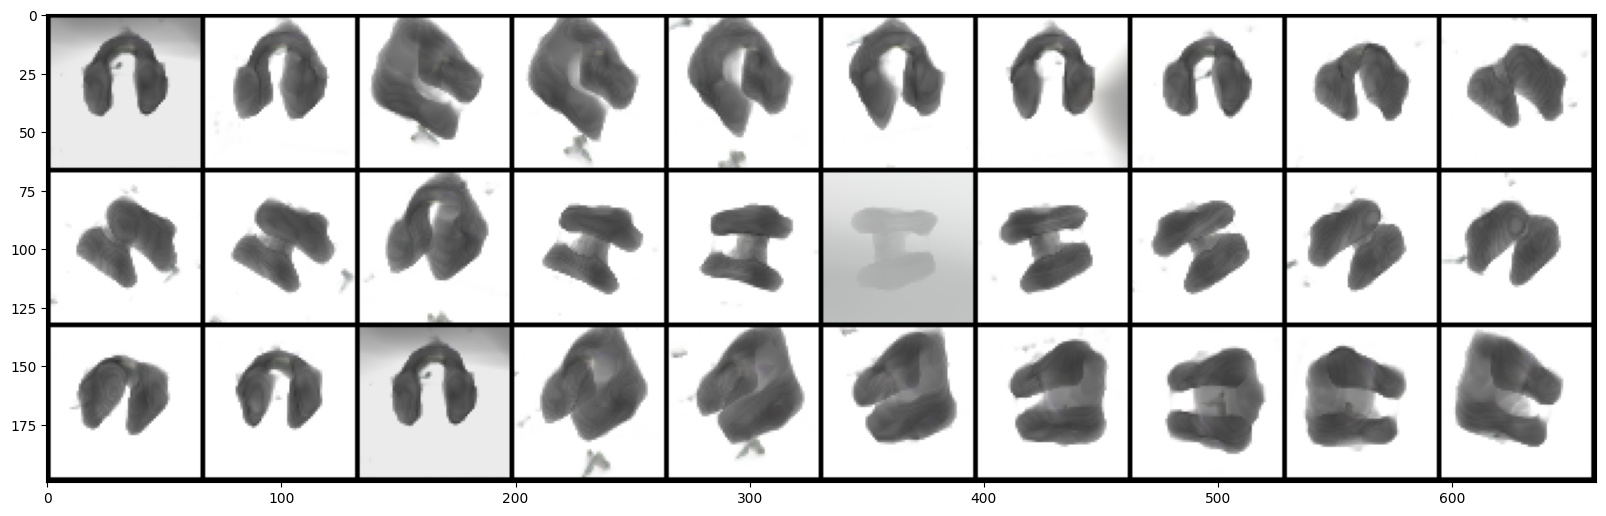

In [ ]:
output = torchvision.utils.make_grid(torch.stack(frames).permute(0, -1, 1, 2), 10)

plt.figure(figsize=(20, 20))
plt.imshow(output.permute(1, 2, 0))